# Разработка моделей машинного обучения для  молочного хозяйства "Вольный луг"

Заказчик проекта - молочное хозяйство "Вольный луг". Необходимо разработать две прогнозные модели машинного обучения:
- Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью моделей нужно отобрать коров из поголовья ассоциации пастбищ "ЭкоФерма" по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным (по критериям заказчика).

Данные для обучения модели предоставлены ассоциацией пастбищ "ЭкоФерма".




## Загрузка данных

In [1]:
%pip install seaborn --upgrade -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install scikit-learn==1.1.3 -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy.stats as st
import math 
from scipy.stats import binom, norm
import phik

    
#Библиотеки для машинного обучения
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (r2_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             recall_score, 
                             precision_score, 
                             accuracy_score, confusion_matrix, 
                             precision_recall_curve,
                             roc_curve, 
                             roc_auc_score,
                             ConfusionMatrixDisplay)

import warnings
warnings.filterwarnings("ignore") # отключим предупреждения о возможных ошибках.


#зададим стили для графиков
# Установка стиля с белым фоном, сеткой и палитрой Set2
sns.set_theme(style="whitegrid", palette="Set2")

# Дополнительные настройки (опционально)
plt.rcParams["figure.figsize"] = (10, 6)  # Размер фигур
plt.rcParams["font.size"] = 12            # Размер шрифта
plt.rcParams["grid.color"] = "0.8"        # Цвет сетки
plt.rcParams["grid.linestyle"] = "--"     # Стиль линий

In [5]:
print('Версия sklearn:')
sklearn.__version__

Версия sklearn:


'1.1.3'

In [6]:
# Функция для построения гистограмм
def plot_histograms(df, columns, rows=2):
    """
    Строит гистограммы для указанных числовых столбцов в DataFrame.

    Args:
        df: DataFrame с данными.
        columns: Список названий числовых столбцов.
        rows: Количество рядов в сетке графиков.
    """
    num_plots = len(columns)
    cols = num_plots // rows + (num_plots % rows > 0)  
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  # Преобразуем массив осей в одномерный список

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_ylabel('Количество')

    plt.tight_layout()
    plt.show()


#Функция для загрузки дата сета

def loading_data(file_name, 
                 df_name, sep=',', 
                 graf=True, 
                 missingno=False, 
                 figsize=(15,10), 
                 bins=30):
    
    try:
        df = pd.read_csv('assets/'+  file_name, sep=sep, decimal=",") 
    except:
        df = pd.read_csv('/datasets/' + file_name, sep=sep, decimal=",") 
    
    pd.set_option("display.max_columns", None)
    
    print(df_name)
    display(df.head(5))
    print('-'*80)
    print('Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти ')
    print()
    print(df.info())
    print('-'*80)
    print('Оценим количество пропущенных значений в каждом столбце')
    print()
    display(df.isna().sum())
    
    if missingno == True:
        print('-'*80)
        print('Визуализируем пропуски в данных')
        msno.matrix(df, figsize = (10,8))
    if graf == True:
        plt.show()
        print('-'*80)
        print('Визуализируем общие данные')
        if 'id' in df.columns:
            df_new = df.drop(columns=['id'])
        else:
            df_new = df

        # Вызываем функцию, указав желаемое количество рядов
        numeric_cols = df_new.select_dtypes(include=['number']).columns
        rows = math.ceil(len(numeric_cols)/3)
        plot_histograms(df_new, numeric_cols, rows=rows)
        plt.show()
     
    return df

In [7]:
#Предобработка, удаление явных дубликатов
def remove_duplicates(data, title):
    num_duplicates = data.duplicated().sum()
    if num_duplicates != 0:
        print('Количество явных дубликатов в ', title, ':', data.duplicated()
              .sum())
        print('Размер', title, 'до удаления дубликатов:', data.shape)
        data = data.drop_duplicates(keep = 'first', 
                                    subset=data.columns.difference(['id']))
        print('Размер', title, 'после удаления дубликатов:', data.shape)
        return data
    else:
        print('Явные дубликаты в', title, 'отсутсвуют')
        return data

In [8]:
def my_plot(data, my_title, bins=50, xlabel = 'Значение'):
    # Создаем фигуру с двумя графиками в одном ряду
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Гистограмма с линиями среднего и медианы
    hist_info = ax1.hist(data, bins=bins)
    ax1.vlines(
        x=[data.mean(), data.median()],
        ymin=0,
        ymax=hist_info[0].max(),
        colors='red',
        linestyles=['-', '--'],
        label=['Среднее', 'Медиана']
    )
    ax1.set_title(f'Гистограмма распределения {my_title}')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Частота')
    ax1.grid(True)
    ax1.legend()
    
    # Boxplot с горизонтальной ориентацией
    ax2.boxplot(data, vert=False)
    ax2.set_title(f'Ящик с усами для {my_title}')
    ax2.set_xlabel(xlabel)
    ax2.grid(True)
    
    
    plt.tight_layout()
    plt.show()


In [9]:
# x - столбец для х
# y - cтолбец для y
# cat - список с категориями для которых нужны графики 
# label - список с подписями для х,у,title
def my_scatter_cat (data, x, y, cat, label, line=True):
    col = 3 
    row = 1 if len(cat) <=3 else math.ceil(len(cat)/3)
    width = col*6
    hight = row*6
    fig = plt.figure(figsize=(width, hight))
    gs = fig.add_gridspec(row, col)
    c = 0
    for i in range(row):
        for j in range(col):
            with sns.axes_style("whitegrid"):
                ax1 = fig.add_subplot(gs[i, j])
                ax1 = sns.scatterplot(data, x=x, y=y, hue=cat[c])
                if line == True:
                    ax1.hlines(y=6000,   xmin=x.min(), xmax= x.max(), colors='red', linestyles='dashdot')
                ax1.set_xlabel(label[0])
                ax1.set_ylabel(label[1])
                ax1.set_title(label[2]+cat[c], fontsize=16)
                c += 1
                if c == len(cat):
                    break;
    fig.tight_layout()
    plt.show()

In [10]:
# Создание модели линейной регрессии
# cat_col = список с названием столбцов с категориальными входными признаками
# num_col = список числовых входных признаков

def my_linear_regression(data, y, cat_col, num_col):
    X = data[cat_col + num_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
    X,
    data[y],
    test_size = 0.25, 
    random_state = 42
    )
    print('-'*20)
    print('Размер обучающей выборки:', X_train.shape)
    print('Размер у_train:', y_train.shape)
    print('Размер тестовой выборки:', X_test.shape)
    print('Размер у_test:', y_test.shape)
    print('-'*20)
    
    # создаём пайплайн для подготовки признаков из списка ohe_columns: 
    # SimpleImputer + OHE
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', 
                              handle_unknown='ignore', 
                              sparse=False)
            )
        ]
    )

    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, cat_col),
            ('num', StandardScaler(), num_col)
        ], 
        remainder='passthrough'
    )

    # создаём итоговый пайплайн: подготовка данных и модель
    pipe_final= Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

    # обучаем модель на тренировочной выборке
    score = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring='r2')
    print(f'Предсказание на обучающей выборке: {score.mean().round(2)}')
    
    # обучаем модель на тренировочной выборке
    pipe_final.fit(X_train, y_train)

    # Достаем модель из пайплайна
    linear_model = pipe_final.named_steps['models']
    preprocessor = pipe_final.named_steps['preprocessor']
    processed_data = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()
    processed_df = pd.DataFrame(
    processed_data,
    columns=feature_names,
    index=X_test.index
    )

    # Коэффициенты (веса признаков)
    coefficients = linear_model.coef_

    # Свободный член (intercept)
    intercept = linear_model.intercept_

    print(f"Coefficients: {coefficients}")
    print(f"Intercept: {intercept}")
    
    # Создаем DataFrame для наглядности

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })


    predictions = pipe_final.predict(X_test)
    print('Значение, предсказаное моделью  - \
           Значение целевого признака из тестовой выборки' )
    print(predictions[0],' '*20, y_test.reset_index(drop=True)[0])
    print(predictions[1],' '*20, y_test.reset_index(drop=True)[1])
    print(predictions[2],' '*20, y_test.reset_index(drop=True)[2])
    print(predictions[3],' '*20, y_test.reset_index(drop=True)[3])

    print("-"*20)
    print('Оценим качество полученой модели на тестовой выборке. '
    'Для этого рассчитаем R², проанализируем остатки с помощью графиков.')
    r2 = r2_score(y_test, predictions)
    print(f"R2 LinearRegression = {r2:.3f}")
            
    print("-"*20)
    print('Проведем анализ остатков')

    # перед этим рассчитаем остатки
    residuals = y_test - predictions

    # построим графики по количественным признакам  
    # — гистограмму частотности распределения и диаграмму рассеяния
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))


    ax[0].hist(residuals, bins=30)
    ax[0].set_title('Гистограмма распределения остатков')
    ax[0].set_xlabel('Остатки')

    sns.residplot(
        x= predictions, 
        y = residuals,
        lowess=True,     # Локальное сглаживание
        scatter_kws={'s': 50, 'alpha': 0.6},  # Настройки точек
        line_kws={'color': 'red', 'lw': 2},     # Настройки линии
        ax=ax[1]
    )

    plt.title('Остатки регрессии')
    plt.xlabel('Предсказанное моделью')
    plt.ylabel('Тестовое значение')
    plt.axhline(y=0, color='grey', linestyle='--')  # Нулевая линия
    plt.show()

    ax[1].set_title('Анализ дисперсии')

    plt.show()

    # средняя абсолютную ошибка на тестовых данных 
    mae = mean_absolute_error(y_test, predictions)
    # оценим среднеквадратичную ошибку построенной модели
    mse = mean_squared_error(y_test, predictions)
    # стандартное отклонение
    rmse = mean_squared_error(y_test, predictions, squared=False)

    return {'mae': mae.round(3), 
            'mse': mse.round(3), 
            'rmse': rmse.round(3), 
            'r2': r2.round(3),
            'train_score': score.round(3),
            'X_train': X_train, 
            'X_test': processed_df, 
            'y_test': y_test, 
            'y_train': y_train,
            'coef': coef_df,
            'intercept': intercept,
            'model': linear_model,
            'preprocessor': preprocessor}
    

In [11]:
def my_logistic_regression (data, y, cat_col, num_col):
    X = data[cat_col + num_col]
    print('Входные признаки:')
    display(X.head())
    X_train, X_test, y_train, y_test = train_test_split(
    X,
    data[y],
    test_size = 0.25, 
    random_state = 42,
    stratify=data[y]
    )
    print('-'*20)
    print('Размер обучающей выборки:', X_train.shape)
    print('Размер у_train:', y_train.shape)
    print('Размер тестовой выборки:', X_test.shape)
    print('Размер у_test:', y_test.shape)
    print('-'*20)
    
    # создаём пайплайн для подготовки признаков из списка ohe_columns: 
    # SimpleImputer + OHE
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', 
                              handle_unknown='ignore', 
                              sparse=False)
            )
        ]
    )

    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, cat_col),
            ('num', StandardScaler(), num_col)
        ], 
        remainder='passthrough'
    )

    # создаём итоговый пайплайн: подготовка данных и модель
    pipe_final= Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LogisticRegression(random_state=42))
        ]
    )
    
    # обучаем модель на тренировочной выборке
    accuracy = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring='accuracy')
    print(f'Предсказание на обучающей выборке: {accuracy.mean().round(2)}')
    

    # обучаем модель на тренировочной выборке
    pipe_final.fit(X_train, y_train)

    # Достаем модель из пайплайна
    log_model = pipe_final.named_steps['models']
    preprocessor = pipe_final.named_steps['preprocessor']
    processed_data = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()
    processed_df = pd.DataFrame(
    processed_data,
    columns=feature_names,
    index=X_test.index
    )
    print('Оценим тренировочную выборку после '
    'масштабирования числовых данных и кодирования категориальных данных')
    display(pd.DataFrame(
        preprocessor.transform(X_train),
        columns=feature_names,
        index=X_train.index
    ).head())
    # Коэффициенты (веса признаков)
    coefficients = log_model.coef_

    # Свободный член (intercept)
    intercept = log_model.intercept_
    
    coef = pd.DataFrame(
        coefficients,
        columns=feature_names
    )
    print(f"Coefficients, коэффициенты (веса признаков):")
    display(coef)
    print(f"Свободный член (intercept): {intercept}")

    predictions = pipe_final.predict(X_test)
    print('Значение, предсказаное моделью  - \
           Значение целевого признака из тестовой выборки' )
    print(predictions[0],' '*50, y_test.reset_index(drop=True)[0])
    print(predictions[1],' '*50, y_test.reset_index(drop=True)[1])
    print(predictions[2],' '*50, y_test.reset_index(drop=True)[2])
    print(predictions[3],' '*50, y_test.reset_index(drop=True)[3])

    print("-"*20)
    print('Оценим качество полученой модели на тестовой выборке.')
    acc = accuracy_score(y_test, predictions)
    print(f"accuracy = {acc:.3f}")
    recall = recall_score(y_test, predictions)
    print(f"recall = {recall:.3f}")
    precision = precision_score(y_test, predictions)
    print(f"precision = {precision:.3f}")
    return {'accuracy':acc, 
            'recall': recall.round(3), 
            'precision': precision.round(3), 
            'X_train': X_train, 
            'X_test': processed_df, 
            'y_test': y_test, 
            'y_train': y_train, 
            'predictions': predictions,
            'model': log_model,
            'preprocessor': preprocessor}

ferma_main


id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет

--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%             

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


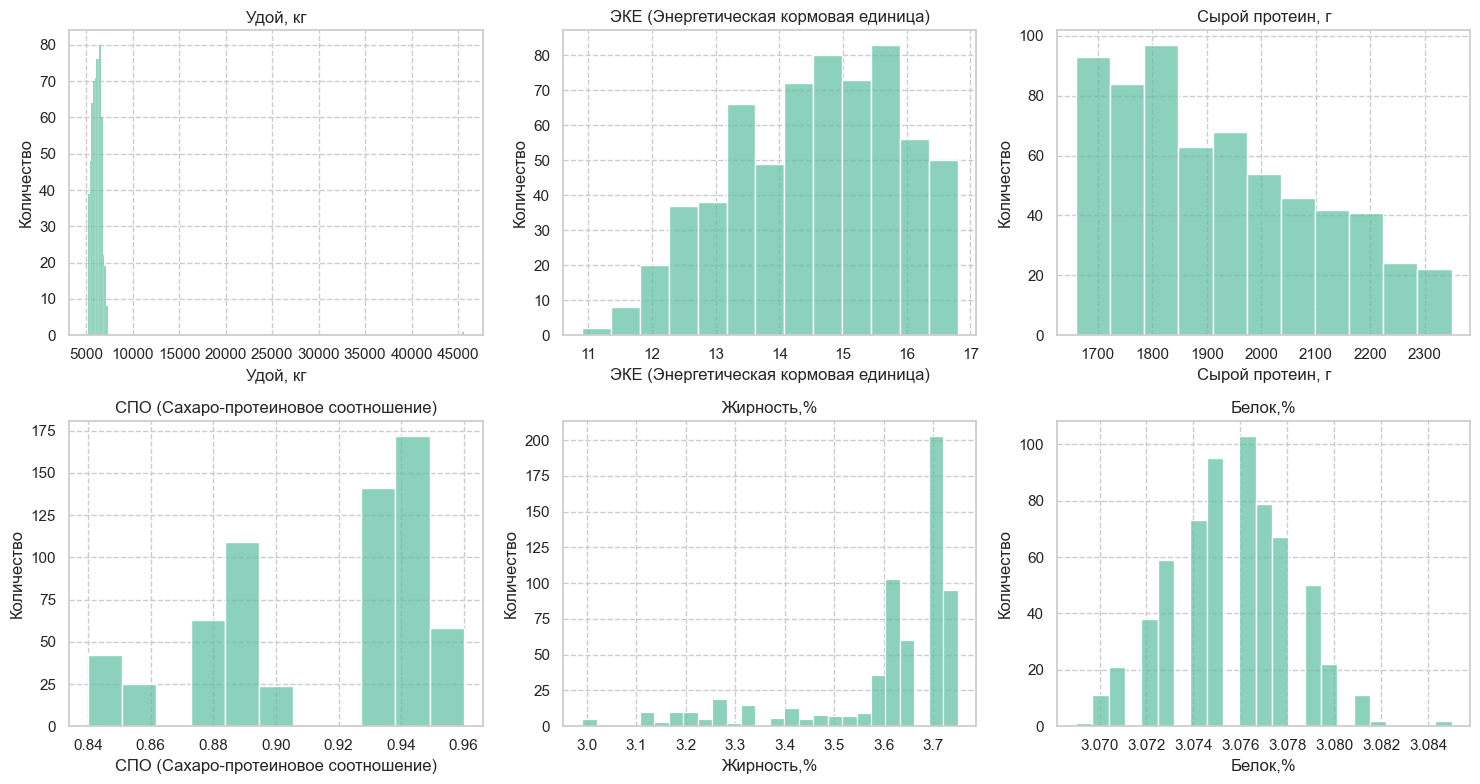

In [12]:
ferma_main = loading_data('ferma_main.csv', 'ferma_main', sep=";")

In [13]:
ferma_dad = loading_data('ferma_dad.csv', 'ferma_dad', ";", graf=False)

ferma_dad


id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id          0
Имя Папы    0
dtype: int64

cow_buy


Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет

--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


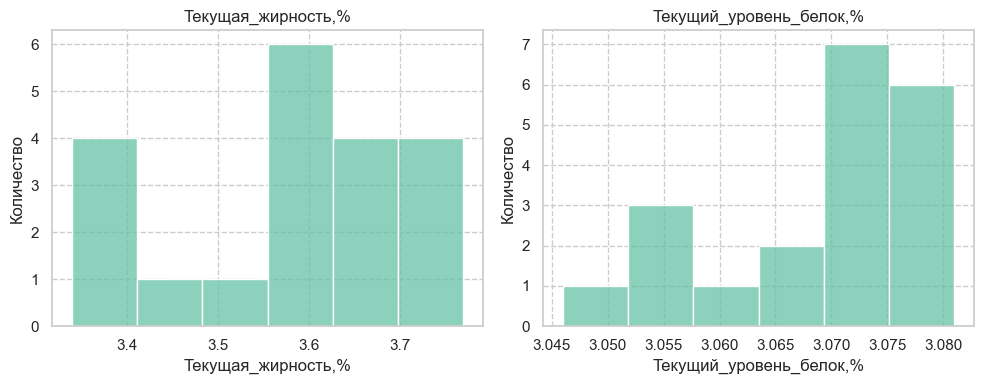

In [14]:
cow_buy = loading_data('cow_buy.csv', 'cow_buy', sep=';' )

Общая предварительная оценка данных:

Датафрейм ferma_main:

- пропуски отсутсвуют,
- типы данных определены верно,
- названия столбцов не соответсвуют стандартам.
- есть выбросы (столбец Удой)

Датафрейм ferma_dad:
- пропуски отсутствуют,
- типы данных заданы правильно,
- названия столбцов не соответсвуют стандартам.

Датафрейм cow_buy:
- пропуски отсутсвуют,
- типы данных заданы правильно.
- названия столбцов не соответсвуют стандартам.

Данные подходят для поставленной задачи.

##  Предобработка данных

#### Изменим названия столбцов в датафреймах в соответсвии со стандартами.

In [15]:
ferma_main = ferma_main.rename(columns={'Удой, кг': 'milk_yield_kg', 
                                        'ЭКЕ (Энергетическая кормовая единица)': 
                                        'energy_feed_unit', 
                                        'Сырой протеин, г': 'crude_protein_g',
                                        'СПО (Сахаро-протеиновое соотношение)': 
                                        'sugar_protein_ratio',
                                        'Порода': 'breed',
                                        'Тип пастбища': 'pasture_type',
                                        'порода папы_быка': 'breed_daddy_bull',
                                        'Жирность,%': 'fat_percent',
                                        'Белок,%': 'protein_percent',
                                        'Вкус молока': 'taste_of_milk',
                                        'Возраст': 'age'})

In [16]:
ferma_main.columns

Index(['id', 'milk_yield_kg', 'energy_feed_unit', 'crude_protein_g',
       'sugar_protein_ratio', 'breed', 'pasture_type', 'breed_daddy_bull',
       'fat_percent', 'protein_percent', 'taste_of_milk', 'age'],
      dtype='object')

In [17]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы': 'dad_name'})

In [18]:
ferma_dad.columns

Index(['id', 'dad_name'], dtype='object')

In [19]:
cow_buy = cow_buy.rename(columns={'Порода': 'breed',
                                  'Тип пастбища': 'pasture_type',
                                  'порода папы_быка': 'breed_daddy_bull',
                                  'Имя_папы': 'dad_name',
                                  'Текущая_жирность,%': 'fat_percent',
                                  'Текущий_уровень_белок,%': 'protein_percent',
                                  'Возраст': 'age'})

In [20]:
cow_buy.columns

Index(['breed', 'pasture_type', 'breed_daddy_bull', 'dad_name', 'fat_percent',
       'protein_percent', 'age'],
      dtype='object')

#### Проверим данные на явные дубликаты

In [21]:
ferma_main = remove_duplicates(ferma_main, 'ferma_main')

Количество явных дубликатов в  ferma_main : 5
Размер ferma_main до удаления дубликатов: (634, 12)
Размер ferma_main после удаления дубликатов: (629, 12)


In [22]:

ferma_dad = remove_duplicates(ferma_dad, 'ferma_dad')

Явные дубликаты в ferma_dad отсутсвуют


#### Проверим на наличие неявных дубликатов

In [23]:
ferma_main['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [24]:
ferma_main['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [25]:
# Удалим неявные дубликаты в столбце Тип пастбища.
ferma_main['pasture_type']= ferma_main['pasture_type'].replace('Равнинные', 
                                                               'Равнинное')
ferma_main['pasture_type'].unique()
# Приведем к нижнему регистру.
ferma_main['pasture_type'] = ferma_main['pasture_type'].str.lower()
ferma_main['pasture_type'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [26]:
ferma_main['breed_daddy_bull'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [27]:
# Удалим неявные дубликаты в столбце порода папы быка
ferma_main['breed_daddy_bull'] = ferma_main['breed_daddy_bull'].replace('Айдиалл', 
                                                                        'Айдиал')
ferma_main['breed_daddy_bull'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [28]:
ferma_dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [29]:
cow_buy['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [30]:
cow_buy['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [31]:
cow_buy['breed_daddy_bull'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [32]:
cow_buy['dad_name'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

- Названия столбцов изменены и соответсвуют стандартам
- Явные дубликаты удалены
- Скрытые дубликаты выявлены и удалены.

Данные готовы для дальнейшего исследования

## Исследовательский анализ данных

In [33]:
ferma_main.describe()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  \
count  629.00000     629.000000        629.000000       629.000000   
mean   315.00000    6188.750397         14.543879      1923.364070   
std    181.72094    1644.795489          1.306408       182.956251   
min      1.00000    5204.000000         10.900000      1660.000000   
25%    158.00000    5751.000000         13.500000      1771.000000   
50%    315.00000    6133.000000         14.700000      1888.000000   
75%    472.00000    6501.000000         15.600000      2062.000000   
max    629.00000   45616.000000         16.800000      2349.000000   

       sugar_protein_ratio  fat_percent  protein_percent  
count           629.000000   629.000000       629.000000  
mean              0.913116     3.603657         3.075671  
std               0.032203     0.168656         0.002549  
min               0.840000     2.990000         3.069000  
25%               0.890000     3.590000         3.074000  
50%               0.930000     3.650000         3.076000  
75%               0.940000     3.720000         3.077000  
max               0.960000     3.750000         3.085000

### Удой, кг (milk_yield_kg)

Столбец Удой (milk_yield_kg) содержит выбросы. Гистограмма при знакомстве с данными показала выброс справа, максимальное значение превышает значение 3 квартиля на порядок, что скорее всего свидетельствует об ошибке, чем о реальном значении. Удалим выбросы из данных.

In [34]:
ferma_main.sort_values(by='milk_yield_kg').tail(5)

id  milk_yield_kg  energy_feed_unit  crude_protein_g  \
294  295           7197              15.6             2241   
296  297           7201              15.8             2077   
135  136           7207              16.6             2343   
70    71           7222              16.8             2157   
16    17          45616              11.5             1675   

     sugar_protein_ratio            breed pasture_type breed_daddy_bull  \
294                 0.94  РефлешнСоверинг    холмистое           Айдиал   
296                 0.94  РефлешнСоверинг    холмистое           Айдиал   
135                 0.94   Вис Бик Айдиал    холмистое           Айдиал   
70                  0.95   Вис Бик Айдиал    холмистое           Айдиал   
16                  0.93   Вис Бик Айдиал    холмистое           Айдиал   

     fat_percent  protein_percent taste_of_milk          age  
294         3.71            3.075        вкусно  более_2_лет  
296         3.71            3.072        вкусно  более_2_лет  
135         3.72            3.078        вкусно  более_2_лет  
70          3.70            3.076        вкусно  более_2_лет  
16          3.22            3.076        вкусно  более_2_лет

In [35]:
#Удалим строку с выбросом
ferma_main = ferma_main.sort_values(by='milk_yield_kg')[:-1].reset_index(drop=True)

In [36]:
ferma_main['milk_yield_kg'].describe()

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_yield_kg, dtype: float64

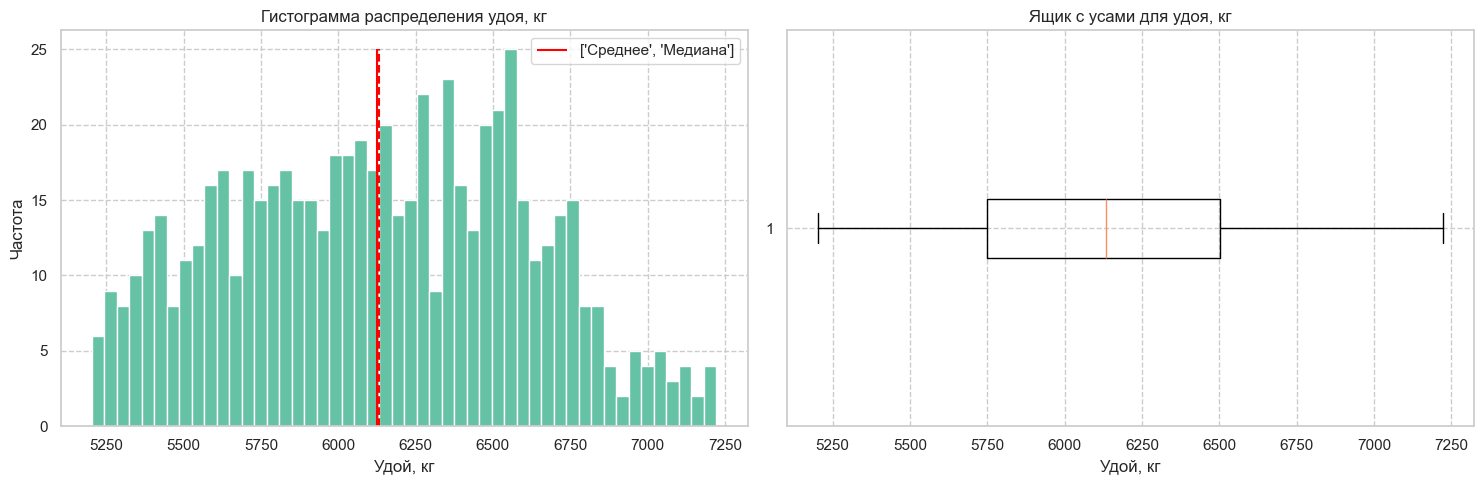

In [37]:
my_plot(ferma_main['milk_yield_kg'], 'удоя, кг', xlabel='Удой, кг')


['milk_yield_kg'] (Удой, кг)

- Выбросы отсутствуют
- Все значения лежат в пределах 1.5 квартилей
- распределение похоже на нормальное
- Среднее и медианное значение практически совпадают и превышают 6000 кг в год.

### ЭКЕ (Энергетическая кормовая единица), energy_feed_unit 

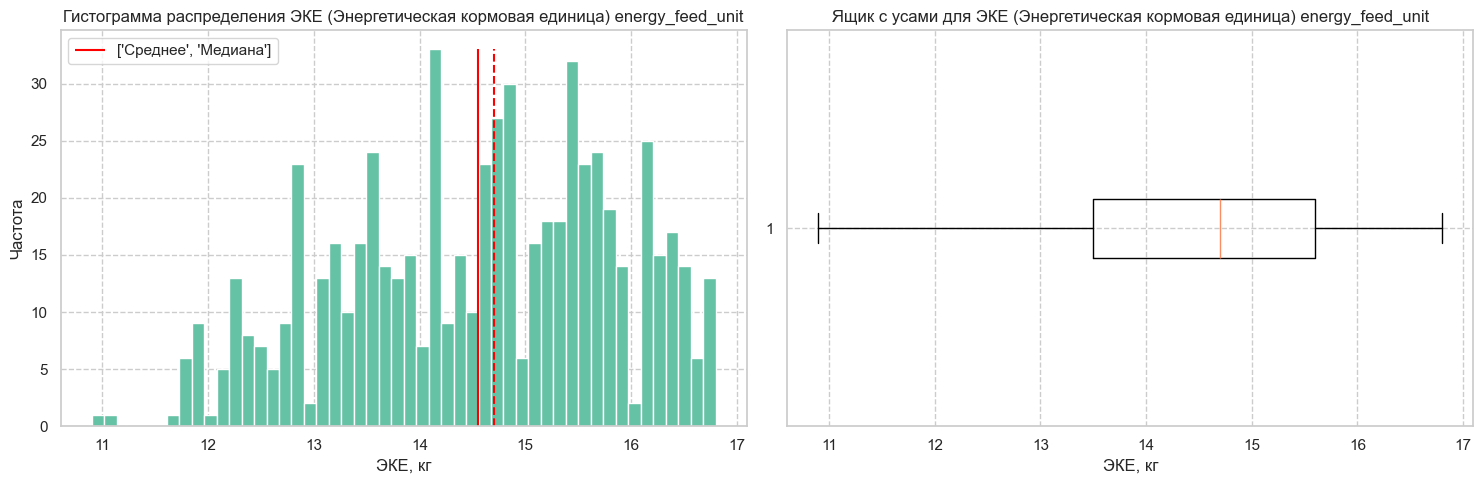

In [38]:
my_plot(ferma_main['energy_feed_unit'], 
        'ЭКЕ (Энергетическая кормовая единица) energy_feed_unit', 
        xlabel='ЭКЕ, кг')


['energy_feed_unit'] (ЭКЕ (Энергетическая кормовая единица))

- Гистограмма показывает смещенное нормальное распределение
- Все значения укладываются в 1.5 межквартильное расстояние.


###  Сырой протеин, г (crude_protein_g)

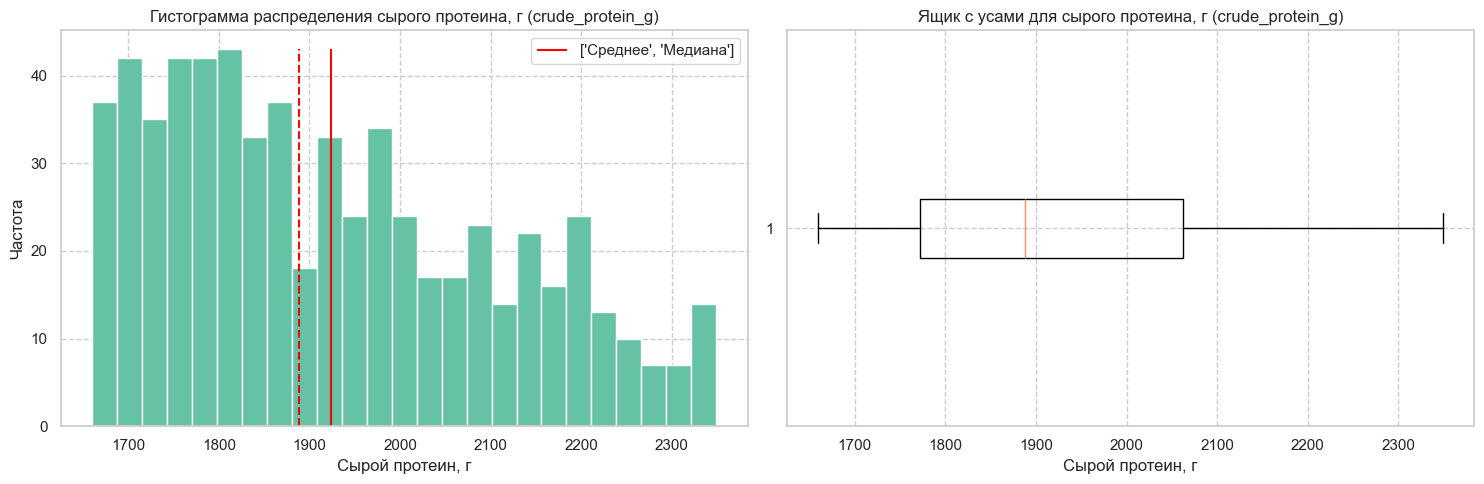

In [39]:
my_plot(ferma_main['crude_protein_g'], 
        'сырого протеина, г (crude_protein_g)',
        25, 
        xlabel='Сырой протеин, г')

['crude_protein_g'] (Сырой протеин, г)

- Гистограмма похожа на распределение Пуассона
- Выбросы отсутсвуют
- Все значения укладываются в 1.5 межквартильный размах.

### СПО (Сахаро-протеиновое соотношение), sugar_protein_ratio

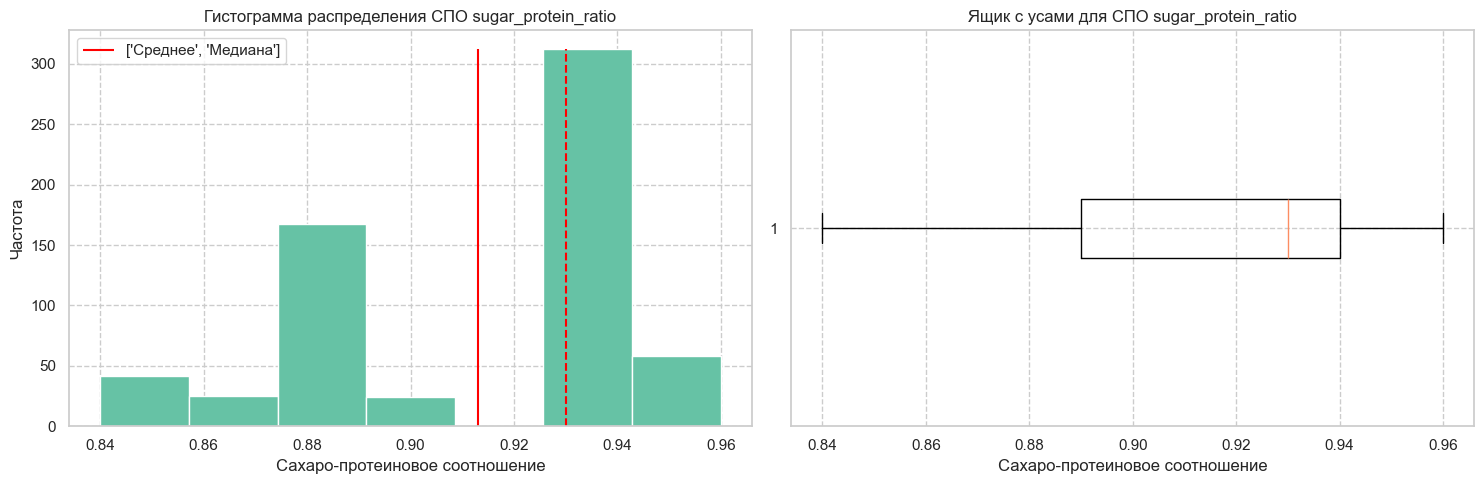

In [40]:
my_plot(ferma_main['sugar_protein_ratio'],  
        'СПО sugar_protein_ratio', 
        7, 
        xlabel='Сахаро-протеиновое соотношение')

ferma_main['sugar_protein_ratio'] СПО (Сахаро-протеиновое соотношение)

- Ящик с усами - смещение вправо
- Среднее значение не соответсвует ни одну из реальных показателей. В качестве среднего лучше использовать медиану. 

### Жирность,% (fat_percent)

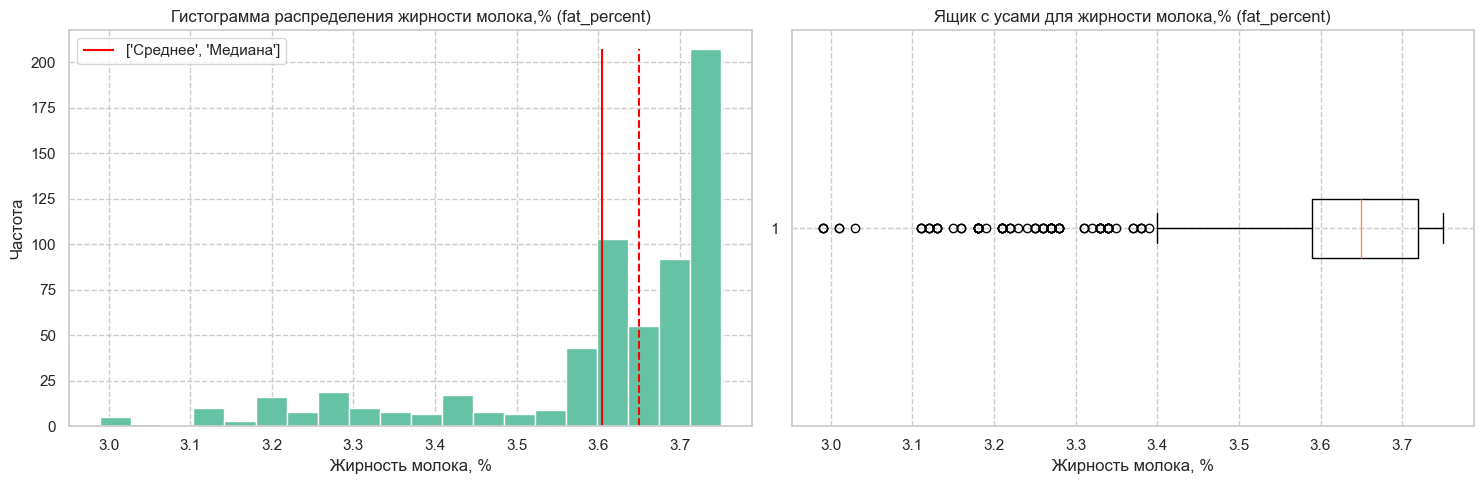

In [41]:
my_plot(ferma_main['fat_percent'],  
        'жирности молока,% (fat_percent)', 
        20, 
        xlabel='Жирность молока, %')

['fat_percent'] Жирность,%

- Ящик с усами смещение вправо, с левой стороны аномальные значения, которые имеют место быть, поэтому оставим их в датасете.
- Гистограмма не похожа на нормальное распределение (отсутсвуюет правая часть)

### Белок,% (protein_percent)

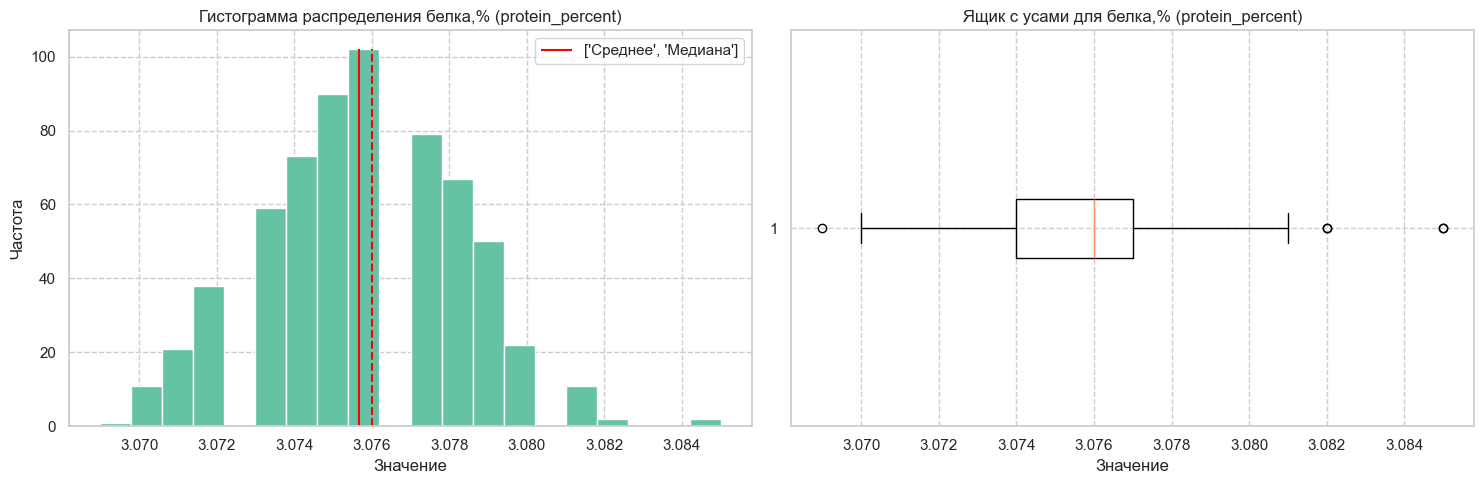

In [42]:
my_plot (ferma_main['protein_percent'],  
         'белка,% (protein_percent)', 20)

['protein_percent'] Белок,%

- Распределение нормальное
- Единичные статистические выбросы слева и справа. Данные значения скорее являются аномалиями, чем ошибочными. Оставляем их.
- Ящик с усами симметричный (без смещения)

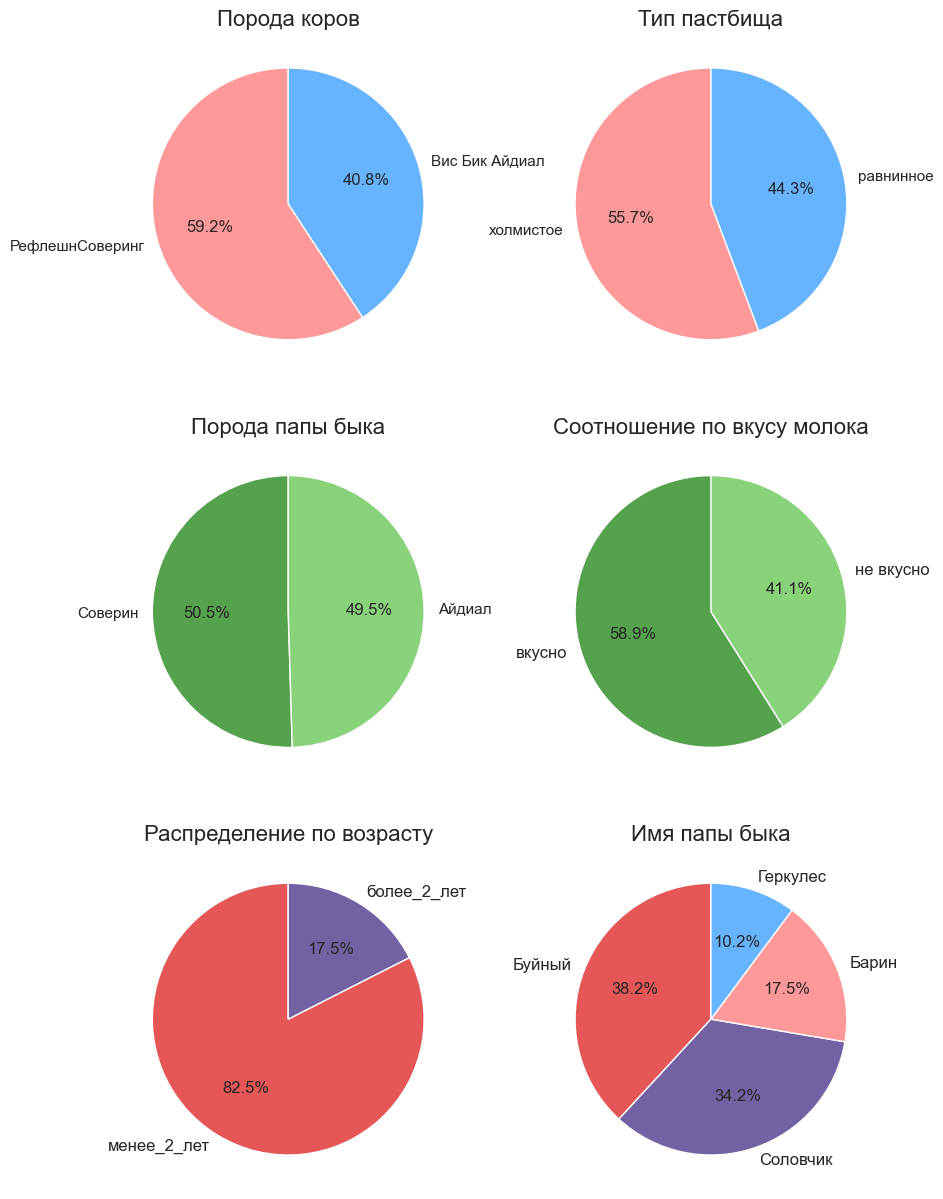

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
# Данные для круговой диаграммы
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # Цвета для секторов
axes = axes.flatten()

# Порода коров
axes[0].pie(
    ferma_main['breed'].value_counts(), 
    labels=ferma_main['breed'].unique(), 
    autopct='%1.1f%%', 
    startangle=90,      
    colors=['#ff9999', '#66b3ff']
)
axes[0].set_title('Порода коров', fontsize=16)

# Тип пастбища
axes[1].pie(
    ferma_main['pasture_type'].value_counts(), 
    labels=ferma_main['pasture_type'].unique(), 
    autopct='%1.1f%%',
    startangle=90,   
    colors=['#ff9999', '#66b3ff']
)
axes[1].set_title('Тип пастбища', fontsize=16)

# Порода папы быка
axes[2].pie(
    ferma_main['breed_daddy_bull'].value_counts(), 
    labels=ferma_main['breed_daddy_bull'].unique(), 
    autopct='%1.1f%%',  
    startangle=90,    
    colors=[ '#54A24B', '#88D27A'] 
)
axes[2].set_title('Порода папы быка', fontsize=16)

# Соотношение по вкусу молока
axes[3].pie(
    ferma_main['taste_of_milk'].value_counts(), 
    labels=ferma_main['taste_of_milk'].unique(), 
    autopct='%1.1f%%', 
    startangle=90,     
    colors=['#54A24B', '#88D27A'],     
    textprops={'fontsize': 12}, 
)
axes[3].set_title('Соотношение по вкусу молока', fontsize=16)

# Распределение по возрасту
axes[4].pie(
    ferma_main['age'].value_counts(), 
    labels=ferma_main['age'].unique(), 
    autopct='%1.1f%%', 
    startangle=90,     
    colors=['#E45756', '#7261A3'],      
    textprops={'fontsize': 12},  
)
axes[4].set_title('Распределение по возрасту', fontsize=16)

# Имя папы быка
axes[5].pie(
    ferma_dad['dad_name'].value_counts(), 
    labels=ferma_dad['dad_name'].unique(), 
    autopct='%1.1f%%', 
    startangle=90,     
    colors=['#E45756', '#7261A3', '#ff9999', '#66b3ff'],     
    textprops={'fontsize': 12},  
)
axes[5].set_title('Имя папы быка', fontsize=16)

plt.show()


### данные о коровах «ЭкоФермы» (коровы на продажу)

In [44]:
cow_buy.describe()

fat_percent  protein_percent
count    20.000000        20.000000
mean      3.577500         3.069500
std       0.126818         0.010339
min       3.340000         3.046000
25%       3.510000         3.064000
50%       3.590000         3.074000
75%       3.650000         3.076000
max       3.770000         3.081000

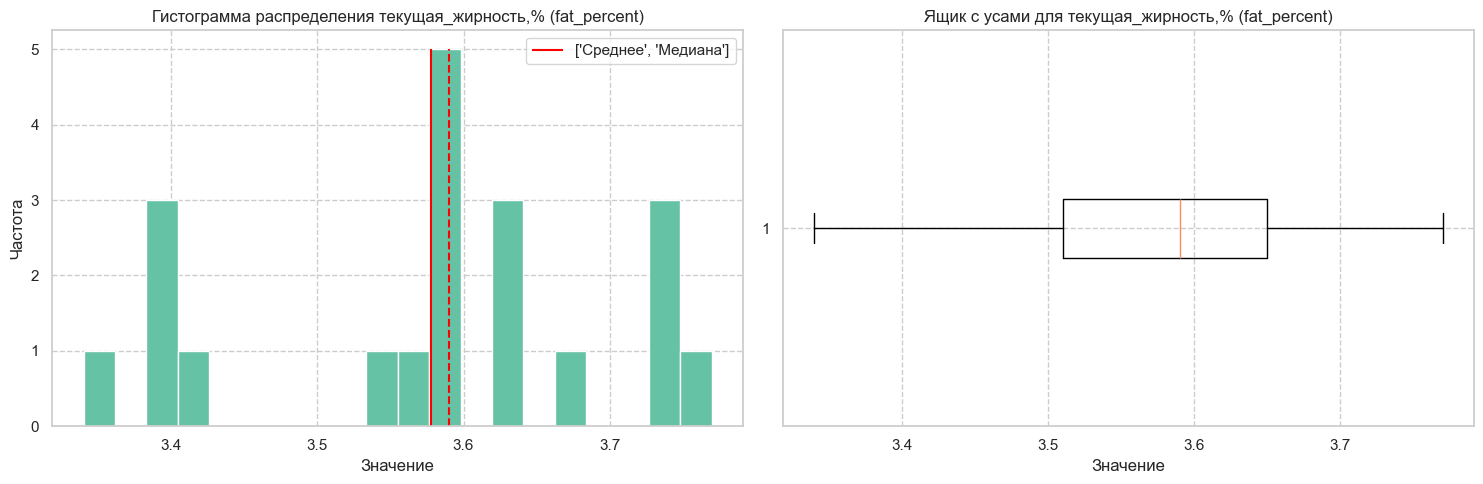

In [45]:
my_plot(cow_buy['fat_percent'], 'текущая_жирность,% (fat_percent)', 20)

['current_fat_percent'], 'текущая_жирность,%
- Выбросы отсутсвуют
- Гистограмма не похожа на нормальное распределение (возможно слишком мало данных)

### Текущий уровень белка ,% (current_protein_percent)

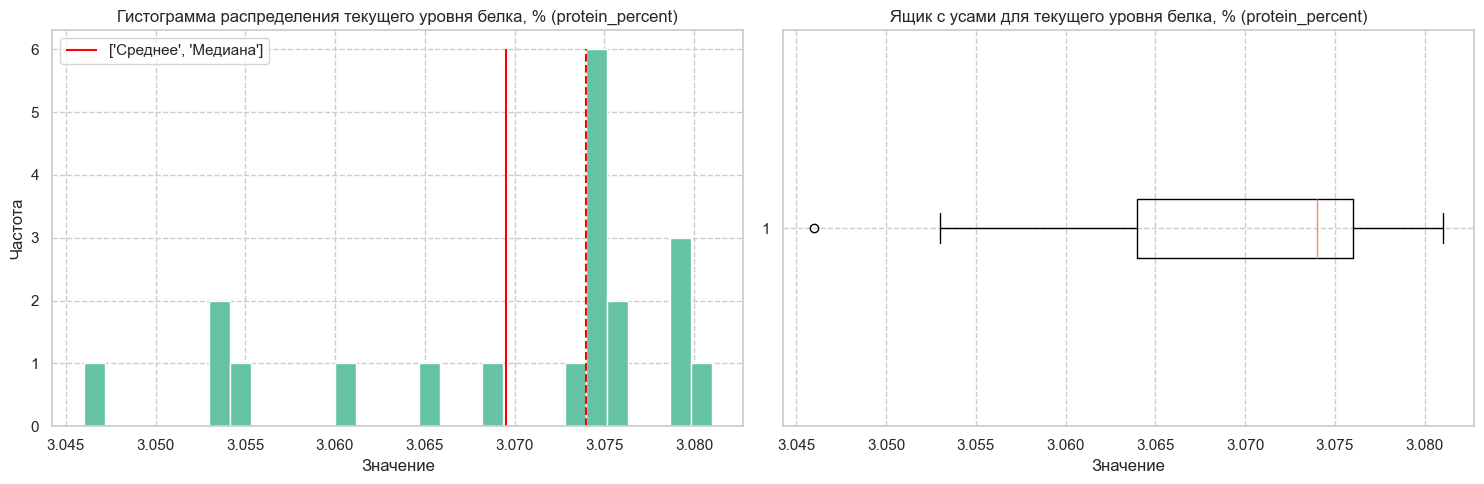

In [46]:
my_plot(cow_buy['protein_percent'], 'текущего уровня белка, % (protein_percent)', 30)

Текущий уровень белка ,% (current_protein_percent)

- На гистограмме выделяется три наиболее часто встречающихся значения 
- Выбросы отсутсвуют
- Ящик с усами с свдигом в право.

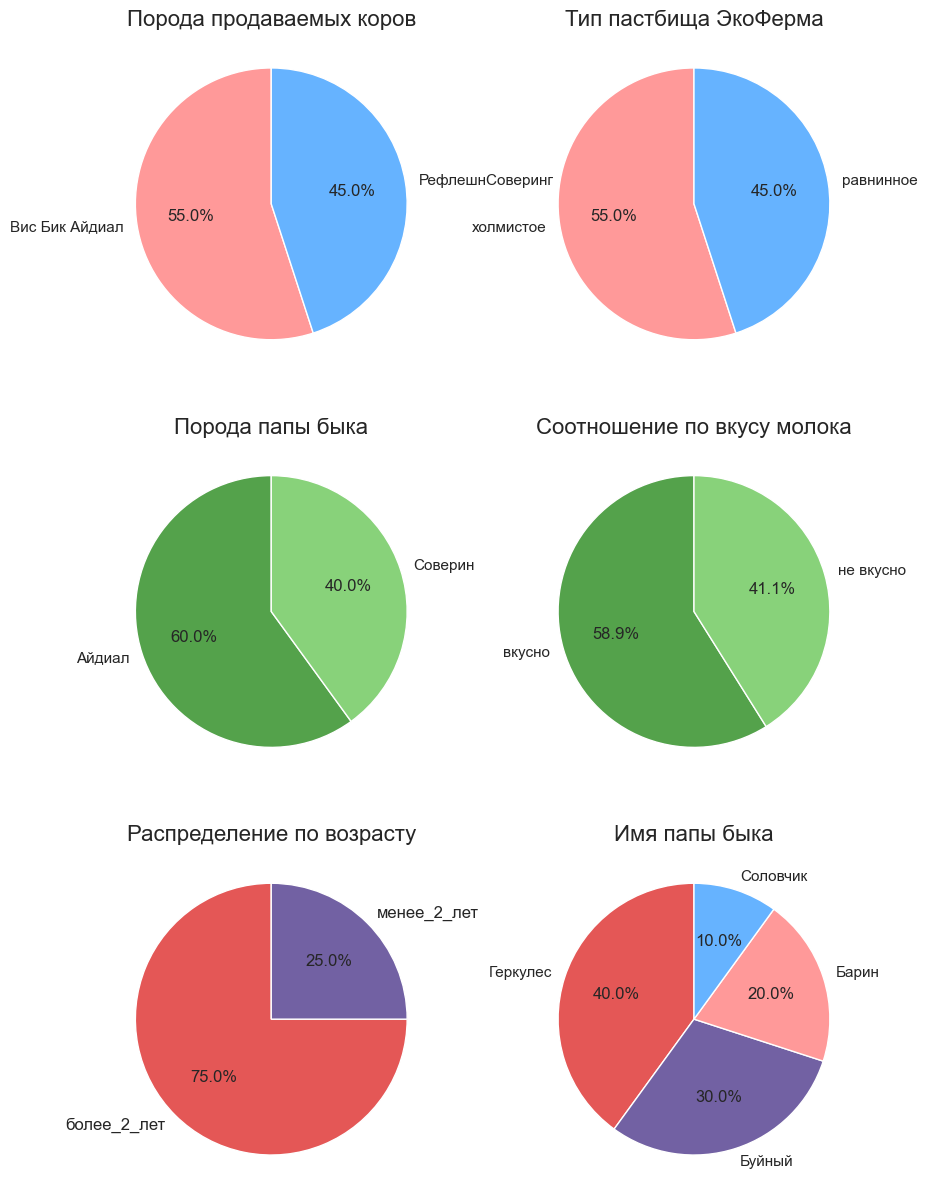

In [47]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
# Данные для круговой диаграммы
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # Цвета для секторов
axes = axes.flatten()

# Порода коров
axes[0].pie(
    cow_buy['breed'].value_counts(), 
    labels=cow_buy['breed'].unique(), 
    autopct='%1.1f%%', 
    startangle=90,      
    colors=['#ff9999', '#66b3ff']
)
axes[0].set_title('Порода продаваемых коров', fontsize=16)

# Тип пастбища ЭкоФерма
axes[1].pie(
    cow_buy['pasture_type'].value_counts(), 
    labels=cow_buy['pasture_type'].unique(), 
    autopct='%1.1f%%',  
    startangle=90,      
    colors=['#ff9999', '#66b3ff'] 
)
axes[1].set_title('Тип пастбища ЭкоФерма', fontsize=16)

# Порода папы быка
axes[2].pie(
    cow_buy['breed_daddy_bull'].value_counts(), 
    labels=cow_buy['breed_daddy_bull'].unique(), 
    autopct='%1.1f%%',  
    startangle=90,      
    colors=[ '#54A24B', '#88D27A'] 
)
axes[2].set_title('Порода папы быка', fontsize=16)

# Соотношение по вкусу молока
axes[3].pie(
    ferma_main['taste_of_milk'].value_counts(), 
    labels=ferma_main['taste_of_milk'].unique(), 
    autopct='%1.1f%%', 
    startangle=90,     
    colors=['#54A24B', '#88D27A']
)
axes[3].set_title('Соотношение по вкусу молока', fontsize=16)

# Распределение по возрасту
axes[4].pie(
    cow_buy['age'].value_counts(), 
    labels=cow_buy['age'].unique(), 
    autopct='%1.1f%%', 
    startangle=90,     
    colors=['#E45756', '#7261A3'],      
    textprops={'fontsize': 12},  
)
axes[4].set_title('Распределение по возрасту', fontsize=16)

# Имя папы быка
axes[5].pie(
    cow_buy['dad_name'].value_counts(), 
    labels=cow_buy['dad_name'].unique(), 
    autopct='%1.1f%%',  
    startangle=90,     
    colors=['#E45756', '#7261A3', '#ff9999', '#66b3ff']
)
axes[5].set_title('Имя папы быка', fontsize=16)

plt.show()

Коровы фермерского хозяйства "Веселый луг"
- Почти 60% буренок породы Вис Бик Айдиал
- 55% выгуливаются на холмистой местности, остальные на равнинной
- Буренки от быков 2-х пород: Соверин и Айдиал
- 60% молока по мнению фермера является вкусным
- 90% буренок старше 2 лет
- Коровы от 4-х быков, 70% от Барин и Буйный.
- Удой 6132.5 +/- 475.9 кг в год.

Молоко и корм "Веселый луг"
- Энергетическая кормовая единица 14.85 +/- 1.18
- Содержание сырого протеина, г 1915.5 +/- 182
- Сахаро-протеиновое соотношение в корме 0.93 +/- 0.03
- содержание жиров, % 3.076 +/- 0.076
- содержание белка, %  3.076 +/- 0.002

Коровы «ЭкоФермы»:
- Равное отношение коров по выгулу на равнинных и холмистых пастбищах.
- Поголовье буренок двух пород в равных отношениях
- Папы - быки двух пород, привалирует порода соверин
- Более 70% коров от быков Буйный и Геркулес
- Почти 70% коров старше 2 лет

Молоко "ЭкоФермы"
- жирность молока медианное значение 3.585, стандартное отклонение 0.142
- уровень белка практически постоянный, стандартное отклонение 0.011, медианное значение 3.0735

Данные очищены от выбросов.

## Корреляционный анализ

Посмотрим на корреляционный анализ признаков в датасете с буренками фермера. Изучим взаимосвязь между признаками.

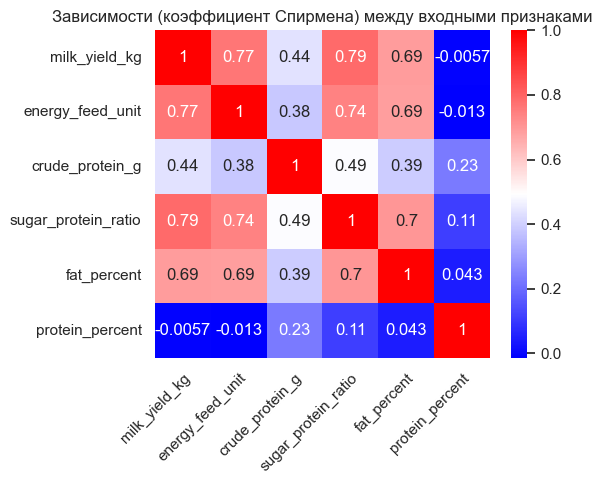

In [48]:
corr = ferma_main[['milk_yield_kg', 
                   'energy_feed_unit', 
                   'crude_protein_g', 
                   'sugar_protein_ratio', 
                   'fat_percent', 
                   'protein_percent' ]].corr(method='spearman')
fig, ax = plt.subplots(figsize=(6,5))
ax = sns.heatmap(corr, annot=True, cmap='bwr')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_title("Зависимости (коэффициент Спирмена) между входными признаками")
fig.tight_layout()
plt.show()



Заметна сильная корреляция удоя от характеристик корма:
- ЭКЕ (Энергетическая кормовая единица)/energy_feed_unit,
- СПО (Сахаро-протеиновое соотношение)/sugar_protein_ratio,

Слабая зависимость от 
- Сырого протеина, г(crude_protein_g)
- Белка, % (protein_percent)

Сильная корреляция удоя от характеристики молока (- Жирности,% (fat_percent)). 



Посмотрим как категориальные характеристики влияют на удой.

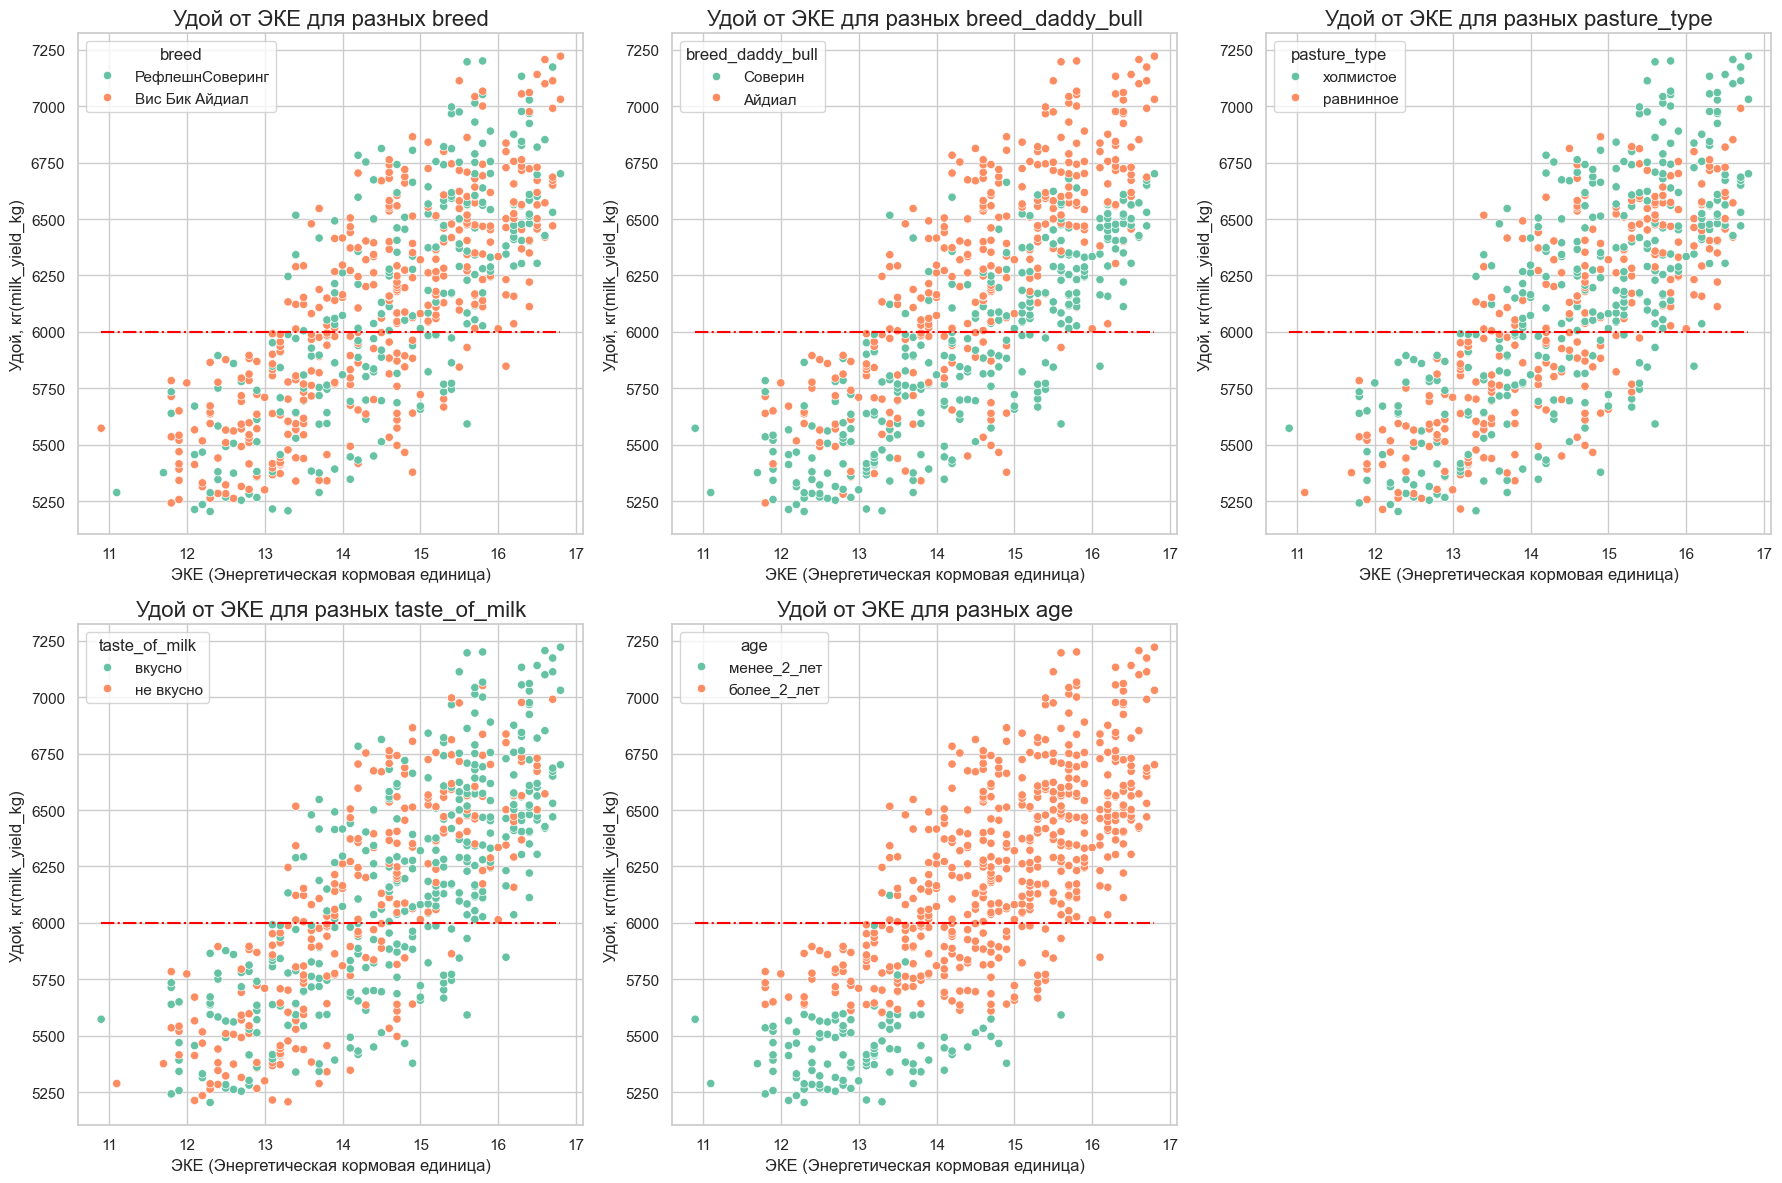

In [49]:
cat = ferma_main[['breed', 'breed_daddy_bull', 'pasture_type', 'taste_of_milk', 'age']].columns
label = ['ЭКЕ (Энергетическая кормовая единица)', 'Удой, кг(milk_yield_kg)', 'Удой от ЭКЕ для разных ']
my_scatter_cat(data=ferma_main, 
               x=ferma_main['energy_feed_unit'], 
               y=ferma_main['milk_yield_kg'], 
               cat=cat,
               label=label)

Сильная зависимость удоя от энергетической кормовой единицы (energy_feed_unit). 
В зависимости от категориальных значений выявлены следующие зависимости:
- от породы папы быка (Айдиал дает больший удой при меньшем значении energy_feed_unit)
- Коровы старше 2 лет дают больший удой
- Максимальные показатели удоя от коров посущихся на холмистых пастбищах.

In [50]:
label = ['Сырой протеин, г(crude_protein_g)', 'Удой, кг(milk_yield_kg)', 'Удой от сырого протеина для разных ']
my_scatter_cat(ferma_main, ferma_main['crude_protein_g'], ferma_main['milk_yield_kg'], cat=cat, label=label)

Диаграмма подтверждает отсуствие линейной зависимости, с учетом того, что коэф. корреляции слабый, данный показатель не будем включать в модель обучения линейной регрессии.

Диаграммы рассеяния удоя (milk_yield_kg) от сыроко протеина (crude_protein_g) аналогично показывают
- потомство быков породы Айдиал дает больший удой
- на холмистых пастбищах удой увеличивается.
- Буренки старше 2 лет дают больше молока.

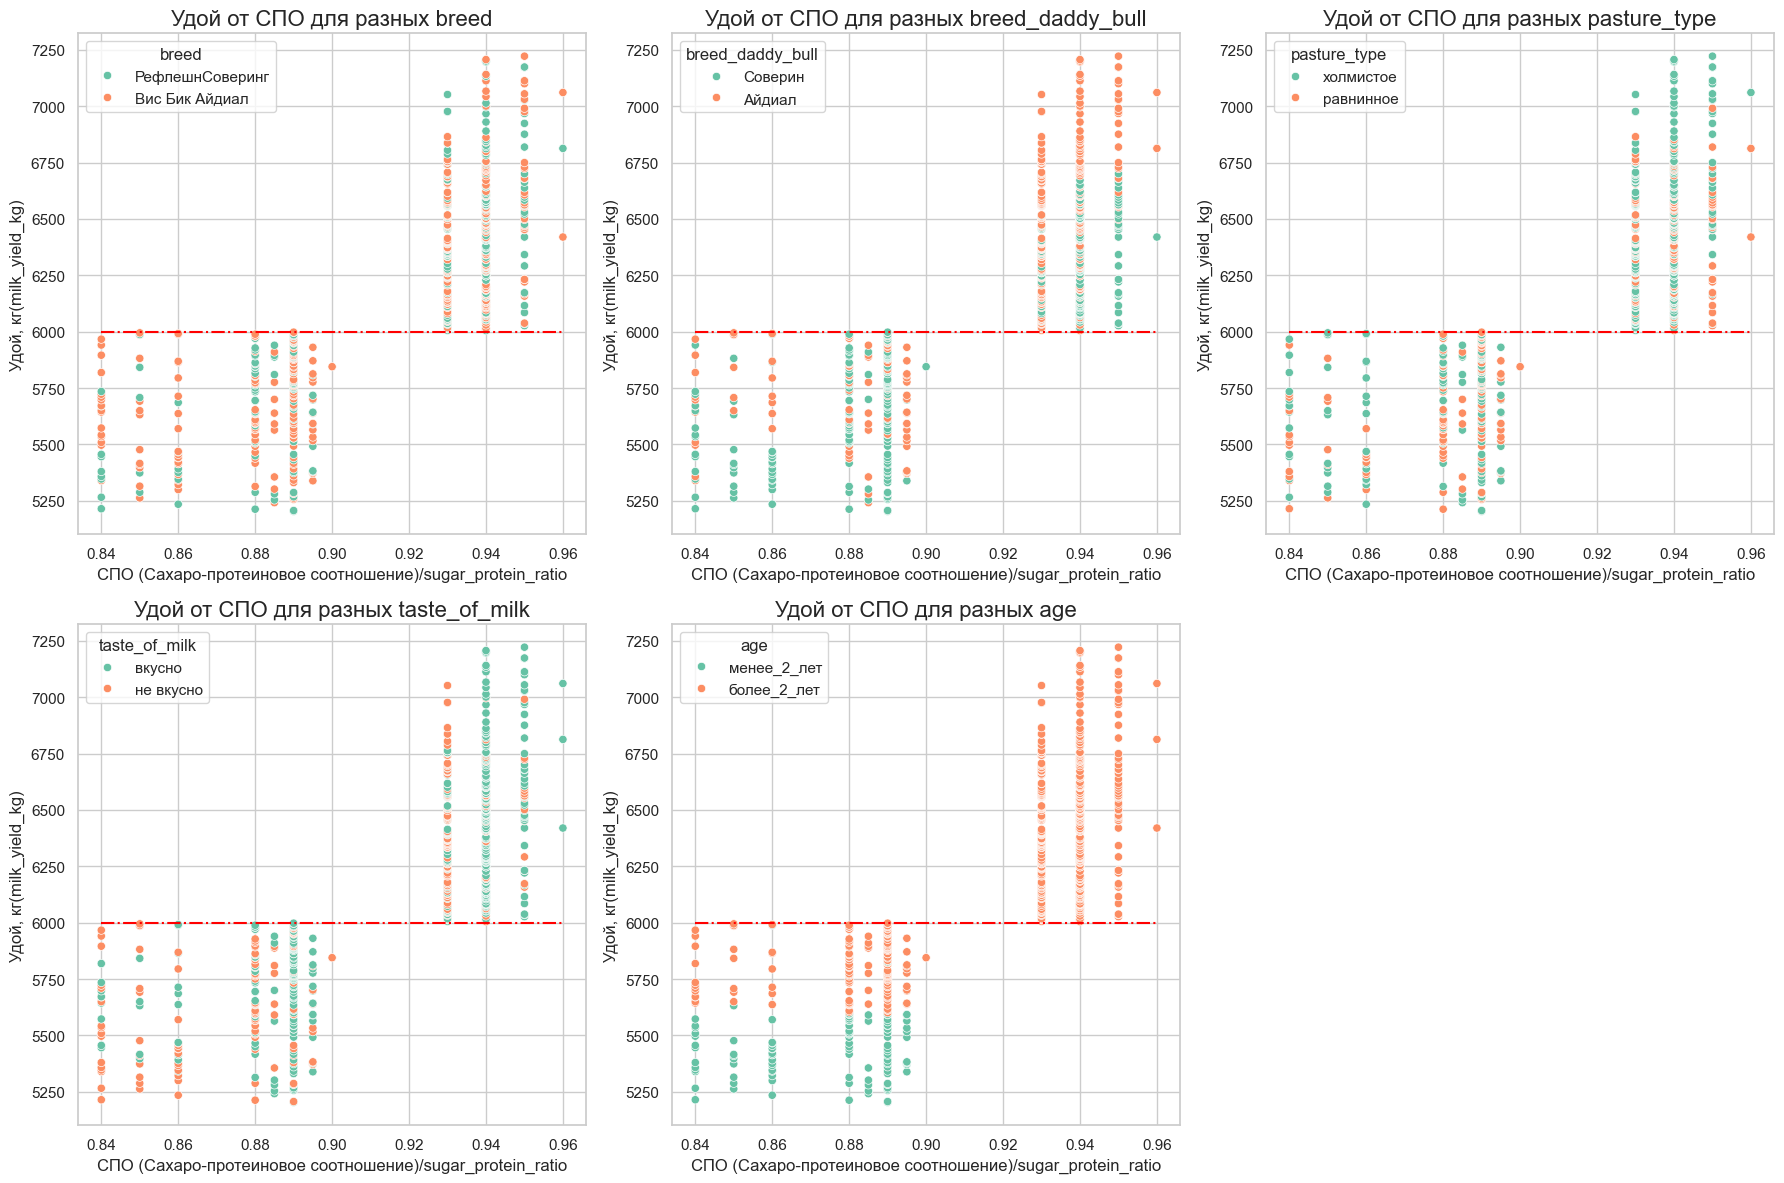

In [51]:
label = ['СПО (Сахаро-протеиновое соотношение)/sugar_protein_ratio', 'Удой, кг(milk_yield_kg)', 'Удой от СПО для разных ']
my_scatter_cat(ferma_main, ferma_main['sugar_protein_ratio'], ferma_main['milk_yield_kg'], cat=cat, label=label)

Распределение на диаграмме рассеяния не похоже на линейную зависимость. Половина данных лежит в одной области, другая половина в другой. 

Помимо уже установленных закономерностей для категориальных признаков можно отметить, что вкусное молоко достигается при высоком значении СПО (sugar_protein_ratio)

In [52]:
label = ['Жирность,%/fat_percent', 'Удой, кг(milk_yield_kg)', 'Удой от жирности молока для разных ']
my_scatter_cat(ferma_main, ferma_main['fat_percent'], ferma_main['milk_yield_kg'], cat=cat, label=label)


Коэф. корреляции сильный, но диаграммы не подтверждают линейной зависимости. 

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


X = add_constant(ferma_main[['energy_feed_unit', 
                              'milk_yield_kg', 
                              'crude_protein_g', 
                              'sugar_protein_ratio', 
                              'fat_percent']])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

               feature          VIF
0                const  1294.939382
1     energy_feed_unit     2.952886
2        milk_yield_kg     3.526865
3      crude_protein_g     1.291610
4  sugar_protein_ratio     3.456363
5          fat_percent     1.870473


Коэффициенты VIF меньше 5, мультиколлинеарность отсутсвует. 

Заметна сильная корреляция удоя от характеристик корма:
- ЭКЕ (Энергетическая кормовая единица)/energy_feed_unit,
- СПО (Сахаро-протеиновое соотношение)/sugar_protein_ratio,

Диаграмма подтверждает отсуствие линейной зависимости
- crude_protein_g (Сырой белок)
с учетом того, что коэф. корреляции слабый, данный показатель не будем включать в модель обучения линейной регрессии.

- Жирности,% (fat_percent))
линейная зависимость не подтверждается, несмотря на высокий коэф. корреляции.

В зависимости от категориальных значений выявлены следующие зависимости:
- от породы папы быка (Айдиал дает больший удой при меньшем значении energy_feed_unit)
- Коровы старше 2 лет дают больший удой
- Максимальные показатели удоя от коров посущихся на холмистых пастбищах.


## Обучение модели линейной регрессии

Для обучения первой модели линейной регрессии в качестве входных признаков возьмем:
- energy_feed_unit
- sugar_protein_ratio
- pasture_type
- breed
- breed_daddy_bull
- age

(Все количественные характеристики, которые показали высокую корреляцию и зависимость от целевого признака подтверждена диаграммой рассеяния. Аналогично с классификационными признаки.)

В качестве целевого признака - milk_yield_kg (удой).

Среди входных признаков присутсвуют категориальные признаки. Закодируем их с помощью OneHotEncoder
Количесвтенные признаки отмасштабируем, чтобы сравнять их веса в модели.

In [54]:
ferma_main.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0  274           5204              12.3             2021                 0.89   
1  398           5207              13.3             1829                 0.89   
2  590           5213              12.1             2016                 0.88   
3  323           5215              13.1             1741                 0.84   
4  579           5235              12.2             1724                 0.86   

             breed pasture_type breed_daddy_bull  fat_percent  \
0  РефлешнСоверинг    холмистое          Соверин         3.27   
1  РефлешнСоверинг    холмистое          Соверин         3.48   
2  РефлешнСоверинг    равнинное          Соверин         3.19   
3  РефлешнСоверинг    равнинное          Соверин         3.18   
4  РефлешнСоверинг    холмистое          Соверин         3.28   

   protein_percent taste_of_milk          age  
0            3.075        вкусно  менее_2_лет  
1            3.077     не вкусно  менее_2_лет  
2            3.076     не вкусно  менее_2_лет  
3            3.070     не вкусно  менее_2_лет  
4            3.078     не вкусно  менее_2_лет

In [55]:
cat_col_names = ['breed', 'pasture_type', 'breed_daddy_bull', 'age']
num_col_names = ['energy_feed_unit',
                 'sugar_protein_ratio']

In [56]:
model_one = my_linear_regression(ferma_main, 
                                  y='milk_yield_kg', 
                                  cat_col=cat_col_names, 
                                  num_col=num_col_names )

--------------------
Размер обучающей выборки: (471, 6)
Размер у_train: (471,)
Размер тестовой выборки: (157, 6)
Размер у_test: (157,)
--------------------
Предсказание на обучающей выборке: 0.79
Coefficients: [  12.10479867   46.82306532 -227.7865432  -241.90864781  153.09894279
  197.91379279]
Intercept: 6255.723672421524
Значение, предсказаное моделью  -            Значение целевого признака из тестовой выборки
6615.497210943304                      6789
6589.075284864832                      6837
6579.367541027909                      6701
6134.782919547888                      5888
--------------------
Оценим качество полученой модели на тестовой выборке. Для этого рассчитаем R², проанализируем остатки с помощью графиков.
R2 LinearRegression = 0.798
--------------------
Проведем анализ остатков


Получившаяся модель неплохо обучилась: 79,8% предсказаний модели ближе к истине, чем среднее значение целевого признака. 

Распределение остатков похоже на нормальное , но если при нормальном распределении частота ошибок должна снижатья по мере удаления от центра распределения, то в реальности мы видим, отсутсувие пика в середине распределения. 
Т.е. мало точных попаданий.

Анализ дисперсии показывает, при увеличиении удоя величина остатков по модулю тоже растет. Паттерн: веерообразная форма → Гетероскедастичность


Точность полученной модели оствляет желать лучшего. Поэтому в новой модели учтем все замечания, которые были сделаны в процессе корреляционного анализа на диаграммах рассеяния.

1. СПО (Сахаро-протеиновое соотношение)/sugar_protein_ratio связаны с удоем нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО (0.915), которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуем СПО в категориальный бинарный признак, использовав эту границу.

2. ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате.




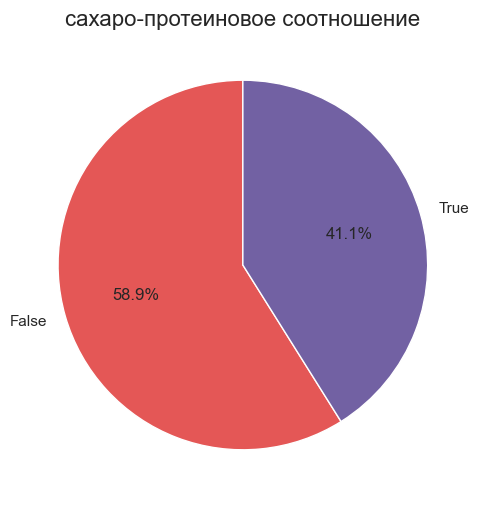

In [57]:
ferma_main['spo_cat'] = ferma_main['sugar_protein_ratio']
ferma_main.loc[(ferma_main['spo_cat'] > 0.915), 'spo_cat'] = True
ferma_main.loc[(ferma_main['spo_cat'] <= 0.915), 'spo_cat'] = False
fig, axes = plt.subplots(1,1)
axes.pie(
    ferma_main['spo_cat'].value_counts(), 
    labels=ferma_main['spo_cat'].unique(), 
    autopct='%1.1f%%',  
    startangle=90,     
    colors=['#E45756', '#7261A3', '#ff9999', '#66b3ff']
)
axes.set_title('сахаро-протеиновое соотношение', fontsize=16)
plt.show()

In [58]:
ferma_main['energy_feed_unit_square'] = ferma_main['energy_feed_unit']**2
ferma_main[['energy_feed_unit', 'energy_feed_unit_square']].describe()

energy_feed_unit  energy_feed_unit_square
count        628.000000               628.000000
mean          14.548726               213.357357
std            1.301777                37.421299
min           10.900000               118.810000
25%           13.500000               182.250000
50%           14.700000               216.090000
75%           15.600000               243.360000
max           16.800000               282.240000

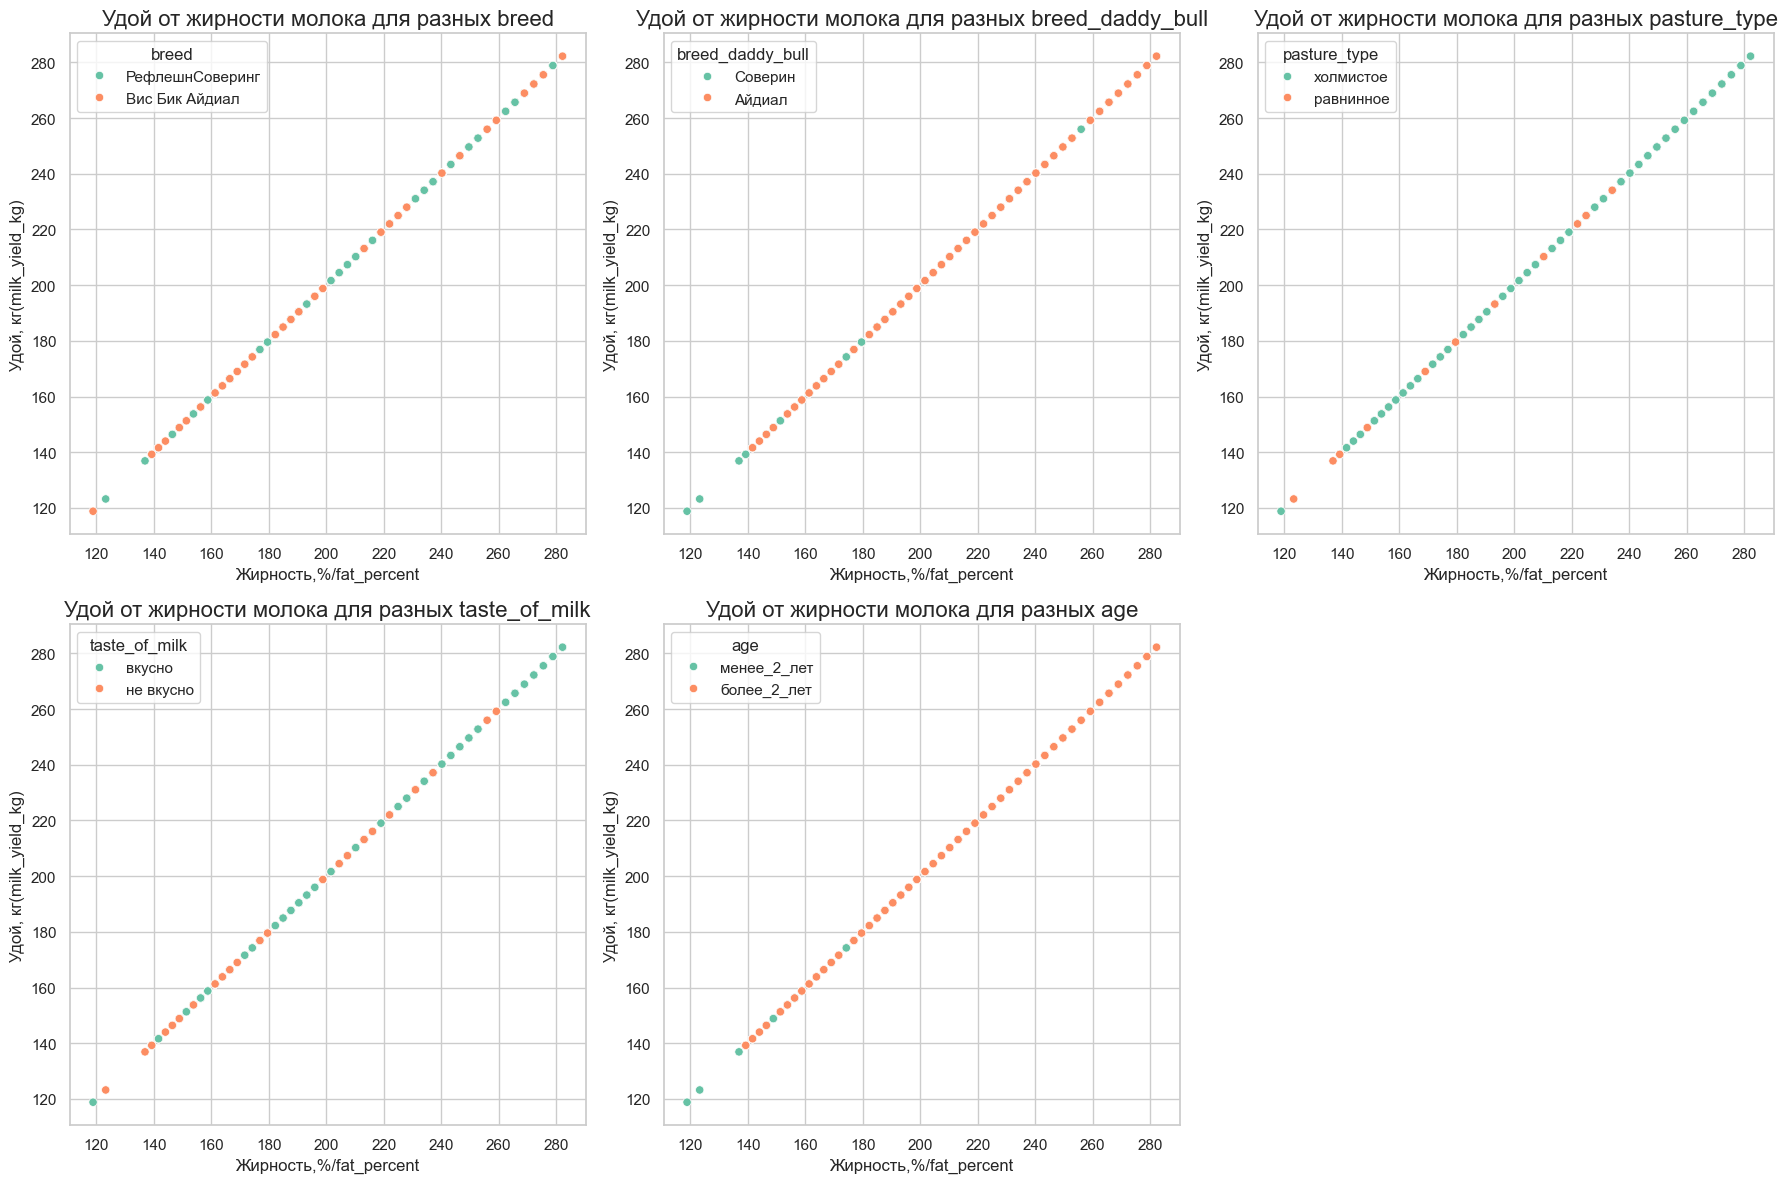

In [59]:
my_scatter_cat(ferma_main, ferma_main['energy_feed_unit_square'], ferma_main['energy_feed_unit_square'], cat=cat, label=label, line=False)

In [60]:
ferma_main.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0  274           5204              12.3             2021                 0.89   
1  398           5207              13.3             1829                 0.89   
2  590           5213              12.1             2016                 0.88   
3  323           5215              13.1             1741                 0.84   
4  579           5235              12.2             1724                 0.86   

             breed pasture_type breed_daddy_bull  fat_percent  \
0  РефлешнСоверинг    холмистое          Соверин         3.27   
1  РефлешнСоверинг    холмистое          Соверин         3.48   
2  РефлешнСоверинг    равнинное          Соверин         3.19   
3  РефлешнСоверинг    равнинное          Соверин         3.18   
4  РефлешнСоверинг    холмистое          Соверин         3.28   

   protein_percent taste_of_milk          age spo_cat  energy_feed_unit_square  
0            3.075        вкусно  менее_2_лет   False                   151.29  
1            3.077     не вкусно  менее_2_лет   False                   176.89  
2            3.076     не вкусно  менее_2_лет   False                   146.41  
3            3.070     не вкусно  менее_2_лет   False                   171.61  
4            3.078     не вкусно  менее_2_лет   False                   148.84

In [61]:
cat_col_names = ['breed', 'pasture_type', 'breed_daddy_bull', 'age', 'spo_cat' ]
num_col_names = ['energy_feed_unit_square',
                 'crude_protein_g',
                 'fat_percent']

--------------------
Размер обучающей выборки: (471, 8)
Размер у_train: (471,)
Размер тестовой выборки: (157, 8)
Размер у_test: (157,)
--------------------
Предсказание на обучающей выборке: 0.83
Coefficients: [  22.33653631   28.693746   -212.22739229 -215.06489187  408.22868819
  132.41797432   47.84579618   21.86946362]
Intercept: 6007.1435587320775
Значение, предсказаное моделью  -            Значение целевого признака из тестовой выборки
6558.885571920519                      6789
6677.560490703792                      6837
6549.00082796535                      6701
6006.640375775322                      5888
--------------------
Оценим качество полученой модели на тестовой выборке. Для этого рассчитаем R², проанализируем остатки с помощью графиков.
R2 LinearRegression = 0.824
--------------------
Проведем анализ остатков


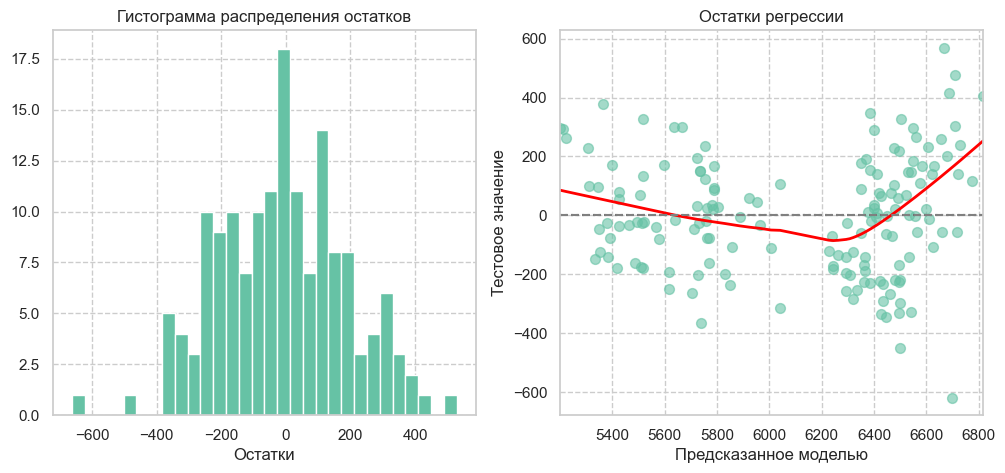

In [62]:
model_two = my_linear_regression(ferma_main,
                                  y='milk_yield_kg',
                                  cat_col=cat_col_names,
                                  num_col=num_col_names)

Качество модели увеличилось более чем на 3 процента и составило 82.4. 
Гистограмма распределения остатков уже больше похожа на нормальное распределение.
Увеличилось число более точных предсказаний (с остатками около 0).
Основная часть остатков лежит в диапазоне +/- 200

Объединим дадасет с коровами фермера с данными об имени папы быка и построим еще одну модель.

In [63]:
ferma_main = ferma_main.merge(ferma_dad, 'left')
ferma_main.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0  274           5204              12.3             2021                 0.89   
1  398           5207              13.3             1829                 0.89   
2  590           5213              12.1             2016                 0.88   
3  323           5215              13.1             1741                 0.84   
4  579           5235              12.2             1724                 0.86   

             breed pasture_type breed_daddy_bull  fat_percent  \
0  РефлешнСоверинг    холмистое          Соверин         3.27   
1  РефлешнСоверинг    холмистое          Соверин         3.48   
2  РефлешнСоверинг    равнинное          Соверин         3.19   
3  РефлешнСоверинг    равнинное          Соверин         3.18   
4  РефлешнСоверинг    холмистое          Соверин         3.28   

   protein_percent taste_of_milk          age spo_cat  \
0            3.075        вкусно  менее_2_лет   False   
1            3.077     не вкусно  менее_2_лет   False   
2            3.076     не вкусно  менее_2_лет   False   
3            3.070     не вкусно  менее_2_лет   False   
4            3.078     не вкусно  менее_2_лет   False   

   energy_feed_unit_square dad_name  
0                   151.29    Барин  
1                   176.89    Барин  
2                   146.41    Барин  
3                   171.61    Барин  
4                   148.84    Барин

In [64]:
cat_col_names = ['breed', 'pasture_type', 'breed_daddy_bull', 'age', 'spo_cat', 'dad_name']
num_col_names = ['energy_feed_unit_square',
                 'crude_protein_g',
                 'fat_percent']

--------------------
Размер обучающей выборки: (471, 9)
Размер у_train: (471,)
Размер тестовой выборки: (157, 9)
Размер у_test: (157,)
--------------------
Предсказание на обучающей выборке: 0.84
Coefficients: [  33.79323489   44.48645931   12.42807707 -196.81491197  380.14767888
  273.00353297  257.29925928   15.29175001  136.92534993   50.85535349
   26.3126967 ]
Intercept: 5772.566111978772
Значение, предсказаное моделью  -            Значение целевого признака из тестовой выборки
6601.013092212011                      6789
6700.091268166941                      6837
6551.290105733632                      6701
5794.301353202056                      5888
--------------------
Оценим качество полученой модели на тестовой выборке. Для этого рассчитаем R², проанализируем остатки с помощью графиков.
R2 LinearRegression = 0.840
--------------------
Проведем анализ остатков


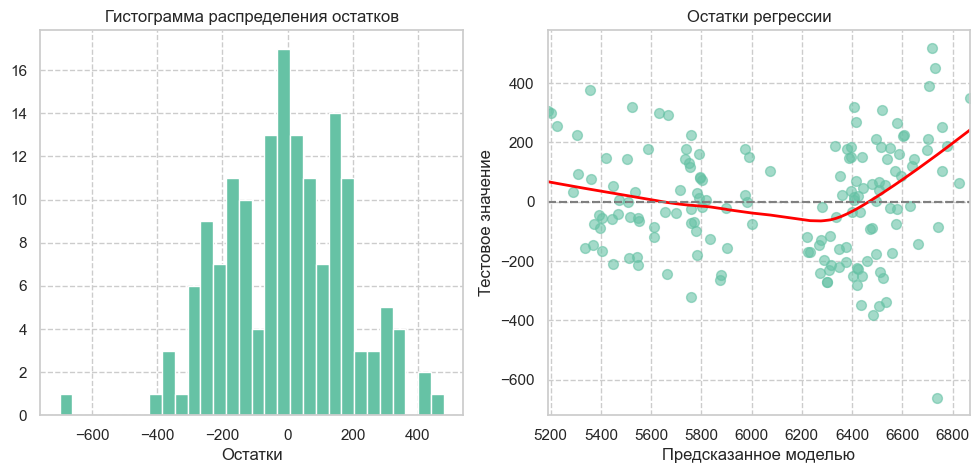

In [65]:
model_three = my_linear_regression(data=ferma_main, y='milk_yield_kg', cat_col=cat_col_names, num_col=num_col_names)

Добавление нового признака повысило качество модели. Метрика R² для третье модели 84 процента.
70 процентов данных имеет осток между тестовым значением и предсказанным не более 200 по модулю. 
Гистограмма имеет нормальное распределение.


Оцените качество каждой модели по трём метрикам: MSE, MAE, RMSE.

In [66]:
print(" "*12, 'MAE'," "*3, 'MSE'," "*5, 'RMSE', " "*2,'R2')
print('-'*45)
print("1. модель:", 
      model_one['mae'], 
      model_one['mse'], 
      model_one['rmse'], 
      model_one['r2'] )
print('-'*45)
print("2. модель:", 
    model_two['mae'],
    model_two['mse'], 
    model_two['rmse'], 
    model_two['r2'])
print('-'*45)
print("3. модель:", 
      model_three['mae'], 
      model_three['mse'], 
      model_three['rmse'], 
      model_three['r2'])

             MAE     MSE       RMSE    R2
---------------------------------------------
1. модель: 176.797 46310.664 215.199 0.798
---------------------------------------------
2. модель: 159.976 40298.214 200.744 0.824
---------------------------------------------
3. модель: 152.234 36654.757 191.454 0.84


Средняя абсолютная ошибка уменьшается от модели к модели, аналогично со среднеквадратичной ошибкой и стандартным отклонением. 
Очевидно, что для прогноза будет использоваться 3 модель. Она ошибается в среднем на 152.234 кг в год  и с вероятностью 84.0 предугадывает верный результат.

<h3>Анализ важности признаков для предсказания с помощью библиотеки SHAP</h3>

In [67]:
model_three['coef']

Feature  Coefficient
0      ohe__breed_РефлешнСоверинг    33.793235
1     ohe__pasture_type_холмистое    44.486459
2   ohe__breed_daddy_bull_Соверин    12.428077
3            ohe__age_менее_2_лет  -196.814912
4               ohe__spo_cat_True   380.147679
5            ohe__dad_name_Буйный   273.003533
6          ohe__dad_name_Геркулес   257.299259
7          ohe__dad_name_Соловчик    15.291750
8    num__energy_feed_unit_square   136.925350
9            num__crude_protein_g    50.855353
10               num__fat_percent    26.312697

In [68]:
model_three['intercept']

5772.566111978772

In [69]:
model_three['X_test'].head()

ohe__breed_РефлешнСоверинг  ohe__pasture_type_холмистое  \
581                         1.0                          1.0   
591                         0.0                          1.0   
550                         1.0                          1.0   
213                         1.0                          1.0   
485                         0.0                          1.0   

     ohe__breed_daddy_bull_Соверин  ohe__age_менее_2_лет  ohe__spo_cat_True  \
581                            0.0                   0.0                1.0   
591                            0.0                   0.0                1.0   
550                            1.0                   0.0                1.0   
213                            0.0                   0.0                0.0   
485                            1.0                   0.0                1.0   

     ohe__dad_name_Буйный  ohe__dad_name_Геркулес  ohe__dad_name_Соловчик  \
581                   1.0                     0.0                     0.0   
591                   0.0                     1.0                     0.0   
550                   0.0                     0.0                     0.0   
213                   0.0                     0.0                     0.0   
485                   0.0                     0.0                     0.0   

     num__energy_feed_unit_square  num__crude_protein_g  num__fat_percent  
581                      0.883641             -0.824470          0.682256  
591                      1.225242              1.177320          0.682256  
550                      1.843724              0.829182          0.503467  
213                     -0.089602             -0.514410         -0.688456  
485                      1.311986             -0.242428          0.741852

In [70]:
import shap
# Создание SHAP 
explainer = shap.LinearExplainer(model_three['model'], model_three['X_test'])

# Вычисление SHAP-значений
shap_values = explainer.shap_values(model_three['X_test'])


SHAP Dependence Plot показывает влияние каждого признака на предсказания модели. 

In [71]:
# Визуализация глобальной важности признаков
shap.summary_plot(shap_values, model_three['X_test'])

График подчеркивает, что ключевыми факторами являются параметры кормления (num_energy_feed_unit_square, num_crude_protein_g). 

Расчитаем доверительный интервал. 

In [72]:
model_three['y_train'].describe()

count     471.000000
mean     6136.061571
std       474.576347
min      5204.000000
25%      5763.500000
50%      6156.000000
75%      6501.500000
max      7222.000000
Name: milk_yield_kg, dtype: float64

In [73]:
#доверительный интервал

distr = st.norm(model_three['y_train'].mean(), model_three['y_train'].std()) 

p_left = (1-model_three['r2'])/2
p_right = 1-p_left

milk_yield_left = distr.ppf(p_left)
milk_yield_right = distr.ppf(p_right)
print(milk_yield_left.round(3), '+/-' , model_three['mae'], '< целевой признак модели <', milk_yield_right.round(3), '+/-' , model_three['mae'])

5469.248 +/- 152.234 < целевой признак модели < 6802.875 +/- 152.234


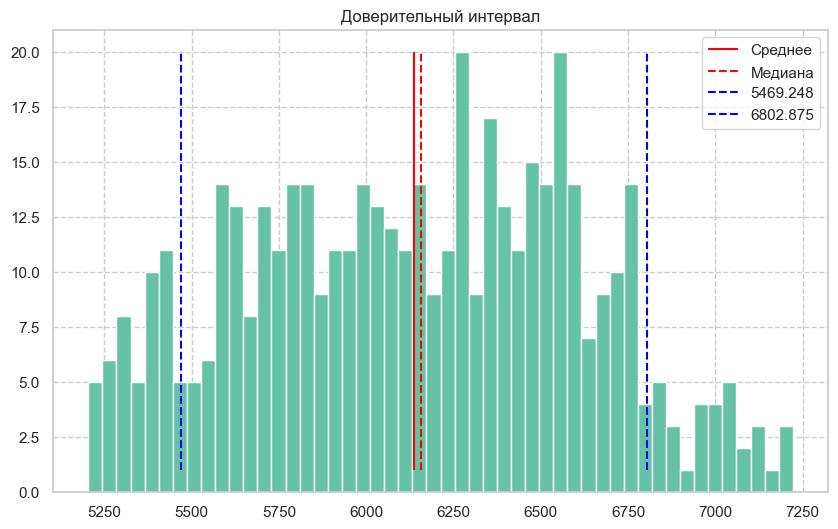

In [74]:

## визуализация распределения целевого признака
# постром частотную гистограмму распределения целевого признака с bins=50
bins = plt.hist(model_three['y_train'], bins=50)
plt.vlines(x=model_three['y_train'].mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
plt.vlines(x=model_three['y_train'].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
plt.vlines(x=milk_yield_left, colors='blue', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label=milk_yield_left.round(3))
plt.vlines(x=milk_yield_right, colors='blue', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label=milk_yield_right.round(3))
plt.title('Доверительный интервал')

plt.legend()
plt.show()



Спрогнозируем удой для коров, которых фермер хочет купить. 

Для этого воспользуемся датасетом cow_buy.

Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
Параметры корма:
- ЭКЕ (Энергетическая кормовая единица), 
- Сырой протеин, г,
- СПО (Сахаро-протеиновое соотношение) отсутствуют. 

Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.

Добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): для этого возьмем из датасета ferma_main средние значения каждого из признаков и увеличим их на 5%.

In [75]:
cow_buy.head()

breed pasture_type breed_daddy_bull  dad_name  fat_percent  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес         3.58   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный         3.54   
2  РефлешнСоверинг    равнинное          Соверин     Барин         3.59   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный         3.40   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный         3.64   

   protein_percent          age  
0            3.076  более_2_лет  
1            3.081  менее_2_лет  
2            3.074  более_2_лет  
3            3.061  более_2_лет  
4            3.074  более_2_лет

In [76]:
ferma_main.head()

id  milk_yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0  274           5204              12.3             2021                 0.89   
1  398           5207              13.3             1829                 0.89   
2  590           5213              12.1             2016                 0.88   
3  323           5215              13.1             1741                 0.84   
4  579           5235              12.2             1724                 0.86   

             breed pasture_type breed_daddy_bull  fat_percent  \
0  РефлешнСоверинг    холмистое          Соверин         3.27   
1  РефлешнСоверинг    холмистое          Соверин         3.48   
2  РефлешнСоверинг    равнинное          Соверин         3.19   
3  РефлешнСоверинг    равнинное          Соверин         3.18   
4  РефлешнСоверинг    холмистое          Соверин         3.28   

   protein_percent taste_of_milk          age spo_cat  \
0            3.075        вкусно  менее_2_лет   False   
1            3.077     не вкусно  менее_2_лет   False   
2            3.076     не вкусно  менее_2_лет   False   
3            3.070     не вкусно  менее_2_лет   False   
4            3.078     не вкусно  менее_2_лет   False   

   energy_feed_unit_square dad_name  
0                   151.29    Барин  
1                   176.89    Барин  
2                   146.41    Барин  
3                   171.61    Барин  
4                   148.84    Барин

In [77]:
ferma_main[['energy_feed_unit_square', 'crude_protein_g', 'sugar_protein_ratio']].describe().round(2)

energy_feed_unit_square  crude_protein_g  sugar_protein_ratio
count                   628.00           628.00               628.00
mean                    213.36          1923.76                 0.91
std                      37.42           182.83                 0.03
min                     118.81          1660.00                 0.84
25%                     182.25          1771.75                 0.89
50%                     216.09          1888.00                 0.93
75%                     243.36          2062.25                 0.94
max                     282.24          2349.00                 0.96

In [78]:
cow_buy['energy_feed_unit_square'] = ((ferma_main['energy_feed_unit'].mean())*1.05)**2
cow_buy['crude_protein_g'] = ferma_main['crude_protein_g'].mean()*1.05
cow_buy['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean()*1.05
cow_buy[['energy_feed_unit_square', 'crude_protein_g', 'sugar_protein_ratio']].describe().round(2)

energy_feed_unit_square  crude_protein_g  sugar_protein_ratio
count                    20.00            20.00                20.00
mean                    233.36          2019.95                 0.96
std                       0.00             0.00                 0.00
min                     233.36          2019.95                 0.96
25%                     233.36          2019.95                 0.96
50%                     233.36          2019.95                 0.96
75%                     233.36          2019.95                 0.96
max                     233.36          2019.95                 0.96

In [79]:

cow_buy['spo_cat'] = cow_buy['sugar_protein_ratio']
cow_buy.loc[(cow_buy['spo_cat'] > 0.915), 'spo_cat'] = True
cow_buy.loc[(cow_buy['spo_cat'] <= 0.915), 'spo_cat'] = False


#milk_yield_prediction = my_linear_regression(ferma_main, 'milk_yield_kg', cat_col=cat_col_names, num_col=num_col_names, X_pred=cow_buy )
#milk_yield_prediction.sort_values(by='milk_yield_kg', ascending=False)


In [80]:
# Закодируем и отмасштабируем данные для предсказания
cow_buy_scaled = (
    model_three['preprocessor']
    .transform(cow_buy[cat_col_names+num_col_names])
    )
# Сделаем предсказание на третьей модели
milk_yield_prediction = model_three['model'].predict(cow_buy_scaled)

# Добавим результат предсказания к датафрейму с коровами Экофермы
cow_buy['milk_yield_kg'] = milk_yield_prediction
cow_buy.sort_values(by='milk_yield_kg', ascending=False)


breed pasture_type breed_daddy_bull  dad_name  fat_percent  \
11  РефлешнСоверинг    равнинное          Соверин  Геркулес         3.73   
15  РефлешнСоверинг    холмистое           Айдиал    Буйный         3.40   
3   РефлешнСоверинг    холмистое           Айдиал    Буйный         3.40   
12   Вис Бик Айдиал    холмистое           Айдиал  Геркулес         3.68   
19  РефлешнСоверинг    равнинное           Айдиал    Буйный         3.64   
4   РефлешнСоверинг    равнинное           Айдиал    Буйный         3.64   
0    Вис Бик Айдиал    холмистое           Айдиал  Геркулес         3.58   
6    Вис Бик Айдиал    холмистое           Айдиал  Геркулес         3.58   
7    Вис Бик Айдиал    равнинное          Соверин    Буйный         3.57   
18   Вис Бик Айдиал    равнинное          Соверин    Буйный         3.34   
17  РефлешнСоверинг    равнинное          Соверин  Геркулес         3.77   
9   РефлешнСоверинг    холмистое           Айдиал    Буйный         3.40   
5   РефлешнСоверинг    равнинное          Соверин  Геркулес         3.63   
16   Вис Бик Айдиал    холмистое          Соверин  Соловчик         3.73   
10   Вис Бик Айдиал    холмистое          Соверин  Соловчик         3.73   
1    Вис Бик Айдиал    равнинное          Соверин    Буйный         3.54   
8   РефлешнСоверинг    равнинное          Соверин     Барин         3.59   
14  РефлешнСоверинг    равнинное          Соверин     Барин         3.59   
2   РефлешнСоверинг    равнинное          Соверин     Барин         3.59   
13   Вис Бик Айдиал    холмистое          Соверин     Барин         3.42   

    protein_percent          age  energy_feed_unit_square  crude_protein_g  \
11            3.073  более_2_лет               233.361138      2019.947532   
15            3.065  более_2_лет               233.361138      2019.947532   
3             3.061  более_2_лет               233.361138      2019.947532   
12            3.046  более_2_лет               233.361138      2019.947532   
19            3.074  более_2_лет               233.361138      2019.947532   
4             3.074  более_2_лет               233.361138      2019.947532   
0             3.076  более_2_лет               233.361138      2019.947532   
6             3.076  более_2_лет               233.361138      2019.947532   
7             3.079  более_2_лет               233.361138      2019.947532   
18            3.069  более_2_лет               233.361138      2019.947532   
17            3.053  менее_2_лет               233.361138      2019.947532   
9             3.079  менее_2_лет               233.361138      2019.947532   
5             3.053  менее_2_лет               233.361138      2019.947532   
16            3.079  более_2_лет               233.361138      2019.947532   
10            3.055  более_2_лет               233.361138      2019.947532   
1             3.081  менее_2_лет               233.361138      2019.947532   
8             3.074  более_2_лет               233.361138      2019.947532   
14            3.074  более_2_лет               233.361138      2019.947532   
2             3.074  более_2_лет               233.361138      2019.947532   
13            3.075  менее_2_лет               233.361138      2019.947532   

    sugar_protein_ratio spo_cat  milk_yield_kg  
11             0.958744    True    6574.855535  
15             0.958744    True    6570.869715  
3              0.958744    True    6570.869715  
12             0.958744    True    6565.280004  
19             0.958744    True    6564.018511  
4              0.958744    True    6564.018511  
0              0.958744    True    6549.598648  
6              0.958744    True    6549.598648  
7              0.958744    True    6531.676404  
18             0.958744    True    6495.609284  
17             0.958744    True    6384.313166  
9              0.958744    True    6374.054803  
5              0.958744    True    6362.359267  
16             0.958744    True    6343.541250  
10             0.958744    True    6343.541

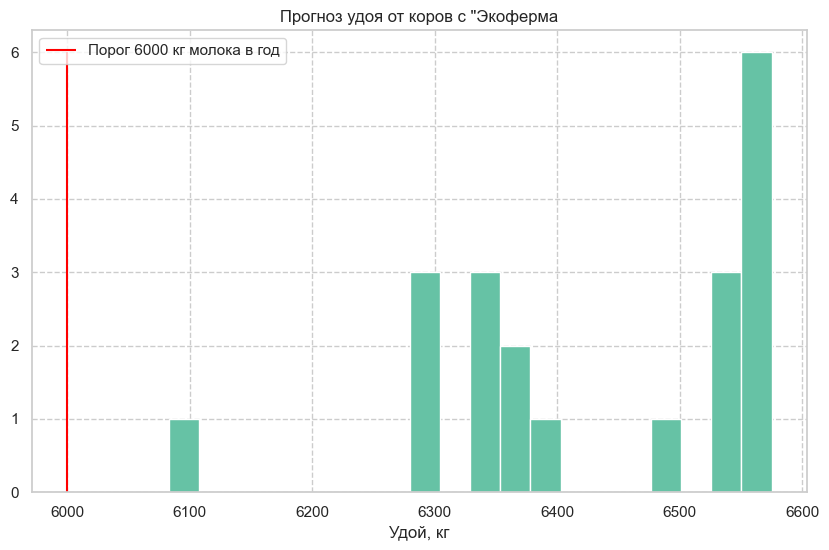

In [81]:
bins = plt.hist(cow_buy['milk_yield_kg'], bins=20)
plt.vlines(x=6000, colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Порог 6000 кг молока в год')
plt.title('Прогноз удоя от коров с "Экоферма')
plt.grid(True)
plt.xlabel('Удой, кг')
plt.legend()
plt.show()

In [82]:
print('Количество буренок с удоем более 6000 кг в год:', cow_buy.query('milk_yield_kg > 6000')['milk_yield_kg'].count())

Количество буренок с удоем более 6000 кг в год: 20


Итак, была построена модель машиного обучения на базе линейной регрессии для прогнозирования удоя коров на основае таких входных признаков как:
- порода буренки
- порода папы быка
- имени папы быка
- типа пастбища
- возраста буренки
- показателя энергетической кормовой единицы
- показателя сырого протеина в корме
- сахаро- протеинового содержания.

Точность модели составляет 83.8%
Абсолютная ошибка прогноза +/- 151 кг молока в год

Модель расчитана на диапазон целевой характеристики от (5601 +/- 151)  до (6813 +/- 151) кг молока в год

На основе полученной модели машинного обучения сделан прогноз удоя для буренок "ЭкоФерма". 
Все буренки предположительно должны дать нужный показатель по удою.

## Обучение модели логистической регрессии

Построим логистическую модель машинного обучения для предсказания вкуса молока у буренок с "ЭкоФерма":

целевой признак "Вкус молока" (taste_of_milk)

Входные признаки определим на основе матрицы корреляции.

In [83]:
num_col_names = ['milk_yield_kg', 
                'energy_feed_unit', 
                'crude_protein_g',
                'sugar_protein_ratio', 
                'fat_percent',
                'protein_percent',
                'energy_feed_unit_square']
cat_col_names = ['taste_of_milk',
                   'milk_yield_kg', 
                   'energy_feed_unit', 
                   'crude_protein_g',
                   'sugar_protein_ratio', 
                   'breed', 
                   'pasture_type', 
                   'breed_daddy_bull',
                   'fat_percent', 
                   'protein_percent',  
                   'age', 
                   'spo_cat',
                   'energy_feed_unit_square', 
                   'dad_name']

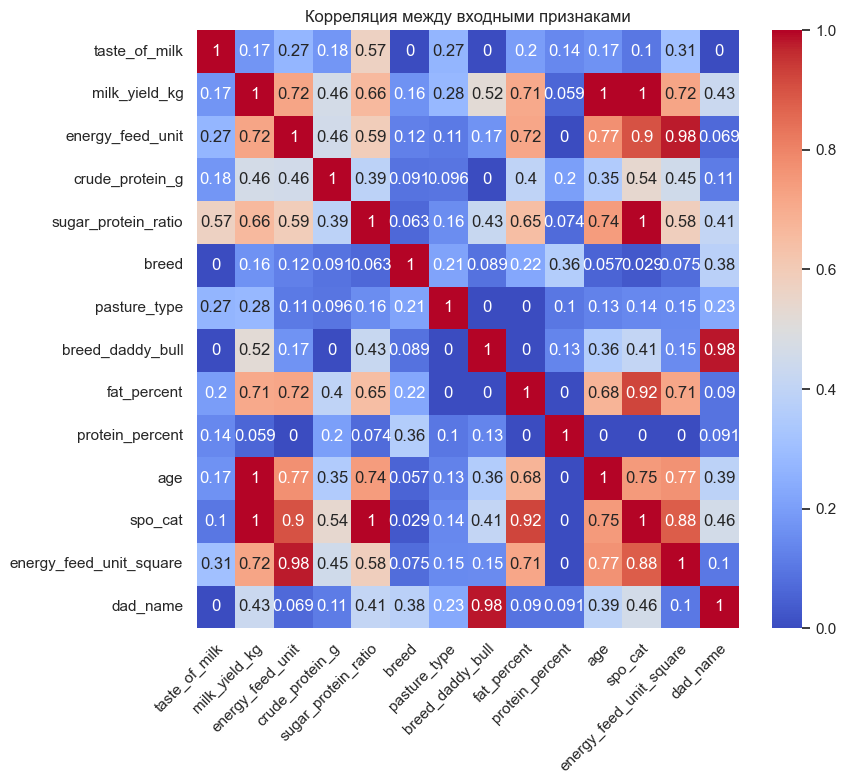

In [84]:

corr = ferma_main[cat_col_names].phik_matrix(interval_cols= num_col_names)

fig = plt.figure(figsize=(9,8))
ax = fig.subplots()
ax = sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_title("Корреляция между входными признаками")
fig.tight_layout()
plt.show()

Матрица корреляция указывает на мультиколлинеарность некоторых признаков (коэфициент корреляции выше 0.9), учтем это при отборе признаков для обучения модели.

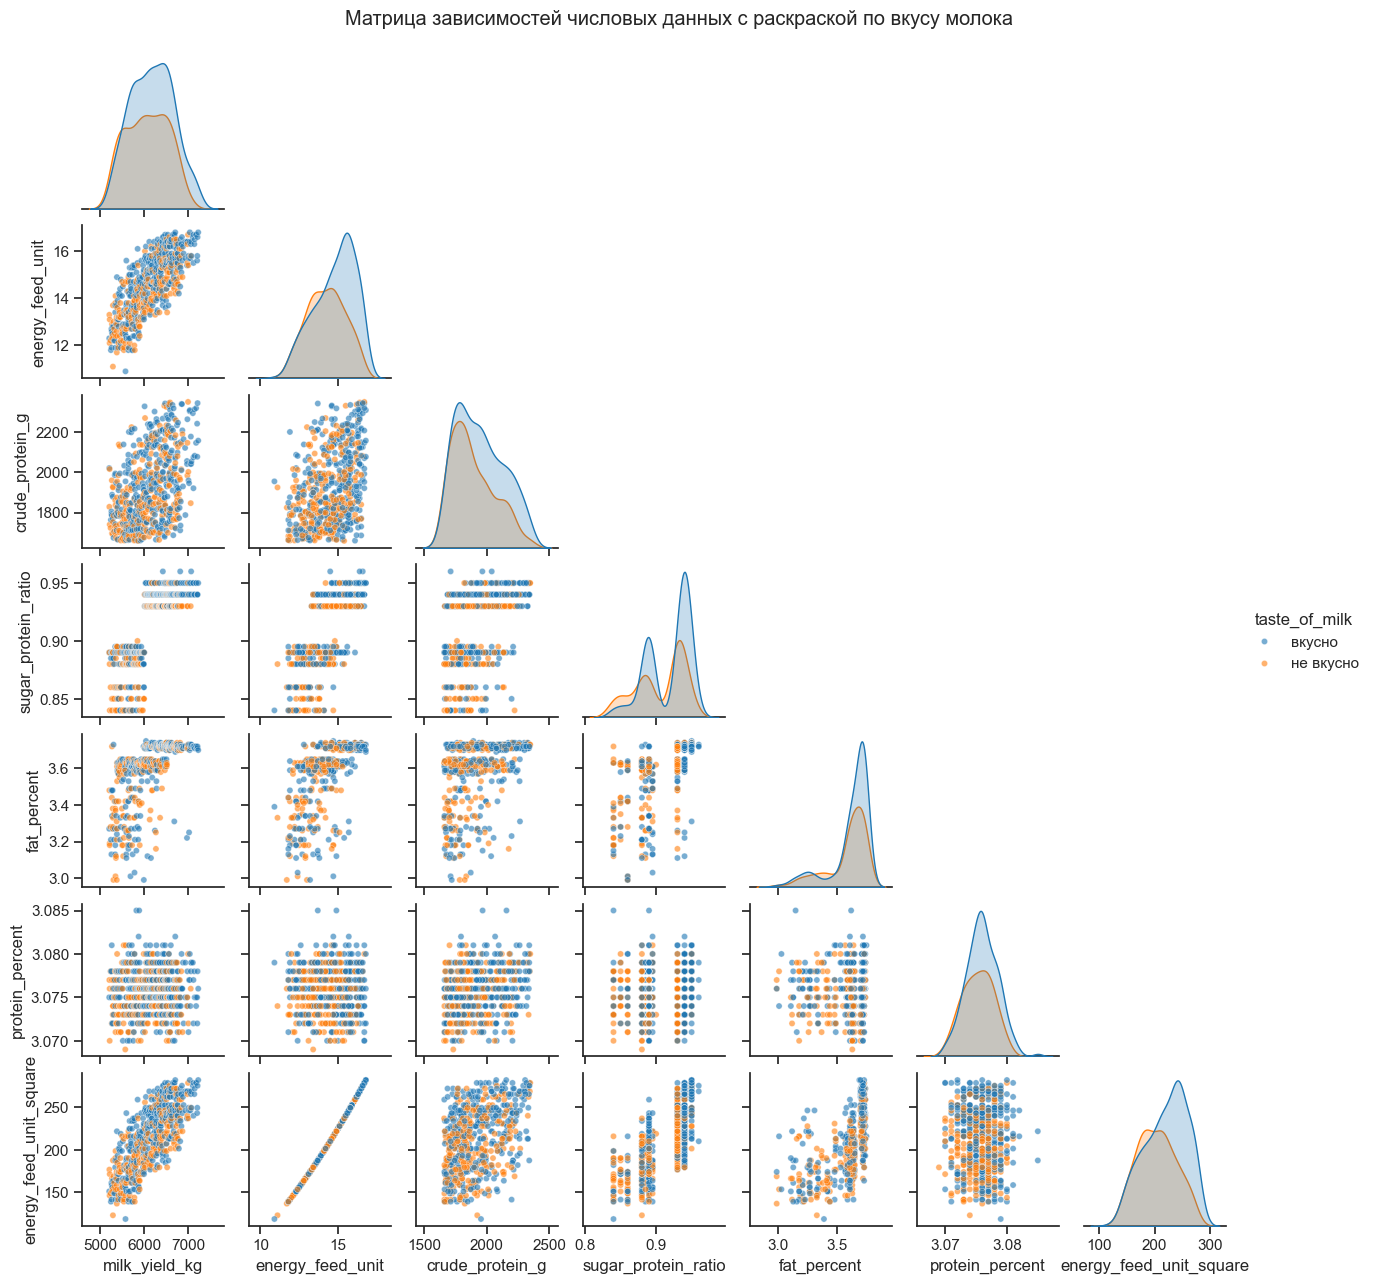

In [85]:
# Настройка стиля
sns.set(style="ticks", palette="tab10")

# Создание матрицы scatterplot'ов
grid = sns.pairplot(
    ferma_main,
    vars=num_col_names,
    hue='taste_of_milk',       
    corner=True,           # Показать не все комбинации
    plot_kws={'alpha': 0.6, 's': 20},  # Настройки точек
    height=1.8,             # Размер каждого субграфика
    aspect=1                # Соотношение сторон
)

plt.suptitle("Матрица зависимостей числовых данных \
с раскраской по вкусу молока", y=1.02)

# Показать график
plt.show()

На основе графиков можно предположить:
- коровы, получающие высоко-энергетическое питание, при этом дающие высокий удой дают вкусное молоко
- молоко с высоким сахаро-протеиновым соотношением скорее вего окажется вкусным

Входные признаки для логистической модели:
- Удой, 'milk_yield_kg', 
- Сырой белок, 'crude_protein_g',
- Сахаро - протеиновое соотношение, 'sugar_protein_ratio', 
- Тип пастбища, 'pasture_type', 
- Жирность молока, 'fat_percent', 
- Содержание белка в молоке, 'protein_percent', 
- ЭКЕ в квадрате,'energy_feed_unit_square'
     

In [86]:
cat_col_names = ['pasture_type']
num_col_names = ['energy_feed_unit_square',
                 'crude_protein_g',
                 'fat_percent',
                 'protein_percent', 
                 'sugar_protein_ratio', 
                 'milk_yield_kg']

ferma_main['taste_of_milk'] = ferma_main['taste_of_milk'].replace(['вкусно', 'не вкусно'], [1, 0])

In [87]:
model_four = my_logistic_regression(ferma_main, 'taste_of_milk', cat_col=cat_col_names, num_col=num_col_names)

Входные признаки:


pasture_type  energy_feed_unit_square  crude_protein_g  fat_percent  \
0    холмистое                   151.29             2021         3.27   
1    холмистое                   176.89             1829         3.48   
2    равнинное                   146.41             2016         3.19   
3    равнинное                   171.61             1741         3.18   
4    холмистое                   148.84             1724         3.28   

   protein_percent  sugar_protein_ratio  milk_yield_kg  
0            3.075                 0.89           5204  
1            3.077                 0.89           5207  
2            3.076                 0.88           5213  
3            3.070                 0.84           5215  
4            3.078                 0.86           5235

--------------------
Размер обучающей выборки: (471, 7)
Размер у_train: (471,)
Размер тестовой выборки: (157, 7)
Размер у_test: (157,)
--------------------
Предсказание на обучающей выборке: 0.62
Оценим тренировочную выборку после масштабирования числовых данных и кодирования категориальных данных


ohe__pasture_type_холмистое  num__energy_feed_unit_square  \
625                          1.0                      0.984086   
290                          1.0                      0.324561   
102                          0.0                     -1.648394   
448                          1.0                      0.899772   
254                          1.0                     -1.104499   

     num__crude_protein_g  num__fat_percent  num__protein_percent  \
625              0.841334          0.649507             -1.482825   
290             -0.305330          0.231423              1.744954   
102             -0.996620         -2.934066              0.534537   
448              1.291222          0.709233             -1.079353   
254             -1.358725         -0.067208             -1.482825   

     num__sugar_protein_ratio  num__milk_yield_kg  
625                  0.858920            2.344740  
290                  0.858920           -0.064619  
102                 -1.010396           -1.112259  
448                  0.547367            0.752842  
254                 -1.633502           -0.256077

Coefficients, коэффициенты (веса признаков):


ohe__pasture_type_холмистое  num__energy_feed_unit_square  \
0                     0.510565                       0.69434   

   num__crude_protein_g  num__fat_percent  num__protein_percent  \
0              0.244107         -0.284456              0.069869   

   num__sugar_protein_ratio  num__milk_yield_kg  
0                  0.301543           -0.490027

Свободный член (intercept): [0.1066253]
Значение, предсказаное моделью  -            Значение целевого признака из тестовой выборки
1                                                    1
1                                                    0
1                                                    1
0                                                    1
--------------------
Оценим качество полученой модели на тестовой выборке.
accuracy = 0.637
recall = 0.772
precision = 0.664


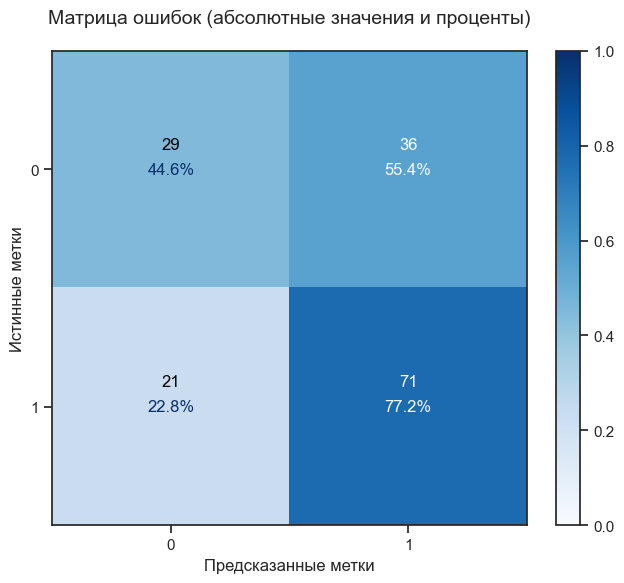

In [88]:
# Создание матрицы ошибок
cm = confusion_matrix(
    model_four['y_test'], 
    model_four['predictions'], 
    labels=model_four['model'].classes_
)

# Нормализация матрицы (проценты вместо абсолютных значений)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots(figsize=(8, 6)) 
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, 
    display_labels=model_four['model'].classes_
)

# Построение тепловой карты
disp.plot(
    cmap='Blues',           
    ax=ax,
    values_format='.1%',     # Формат отображения значений (проценты)
    colorbar=False,          # Убрать встроенную colorbar (добавим свою)
    im_kw={'vmin': 0, 'vmax': 1}  # Диапазон значений для цвета
)

# Добавление аннотаций с абсолютными значениями
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}\n',
                ha='center', va='bottom',
                color='white' if cm_normalized[i, j] > 0.5 else 'black')

plt.title('Матрица ошибок (абсолютные значения и проценты)', 
          fontsize=14, pad=20)
plt.xlabel('Предсказанные метки', fontsize=12)
plt.ylabel('Истинные метки', fontsize=12)
plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)  # Добавление colorbar
plt.tight_layout()
plt.show()

Модель обучена, точность модели не сильно впечатляет, всего 77% Но нужно учесть, что показатель вкуса молока достаточно субъективный. Нам же достаточно минимизировать ложно положительную оценку. Чтобы в конечную выборку не попали коровы, у которых не вкусное молоко. Для этого нам нужно добиться максимально высокого показателя precision


In [89]:
# Объединим в один датасет тестовые и предсказанные значения целевого признака (до его классификации)

y_proba = model_four['model'].predict_proba(model_four['X_test'])[:,1]

data = pd.DataFrame(zip(model_four['y_test'], y_proba),
             columns = ['y_test', 'y_proba']).sort_values(by='y_proba',ascending=False)
display(data.head(5))
#добавим пороги для разделения целевого признака по порогу
#thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 4,endpoint=False)]
#print(thresholds) 

y_test   y_proba
113       1  0.868551
146       1  0.865646
14        1  0.865500
144       1  0.856655
124       1  0.853414

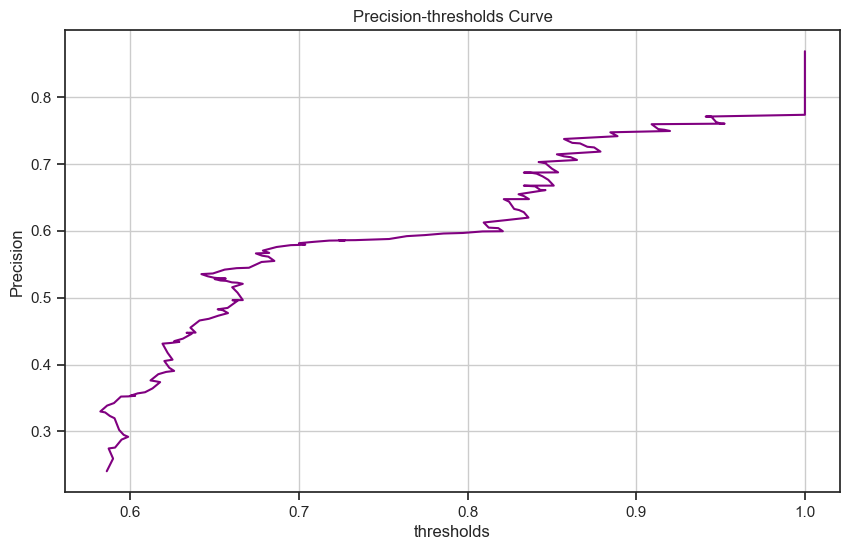

In [90]:
y_scores = np.array(y_proba)
y_true = np.array(model_four['y_test'])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
fig, ax = plt.subplots()
ax.plot(precision[:-1], thresholds, color='purple')

#add axis labels to plot
ax.set_title('Precision-thresholds Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('thresholds')
ax.grid(True)
#display plot
plt.show()


С порога 0.8 precision резко возрастает. Посмотрим, с каким порогом и высоким precision мы сможем набрать нужное количество коров (16) 

In [91]:
# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавьте столбцы с новыми предсказаниями в таблицу
for i in [0.55, 0.6,0.65,0.7,0.75,0.8, 0.85, 0.9]:
	columns.append('y_pred_'+str(i))
	data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

# выведем 5 случайных строк
display(data.sample(5))
print('всего единиц в тестовой:    ', data['y_test'].sum())
print("-"*30)

print('всего единиц в y_pred_0.55: ', data['y_pred_0.55'].sum())
print('всего единиц в y_pred_0.6:  ', data['y_pred_0.6'].sum())
print('всего единиц в y_pred_0.65: ', data['y_pred_0.65'].sum())
print('всего единиц в y_pred_0.7:  ', data['y_pred_0.7'].sum())
print('всего единиц в y_pred_0.75: ', data['y_pred_0.75'].sum())
print('всего единиц в y_pred_0.8:  ', data['y_pred_0.8'].sum())
print('всего единиц в y_pred_0.85: ', data['y_pred_0.85'].sum())
print('всего единиц в y_pred_0.9:  ', data['y_pred_0.9'].sum())


y_test   y_proba  y_pred_0.55  y_pred_0.6  y_pred_0.65  y_pred_0.7  \
12        1  0.328414            0           0            0           0   
37        1  0.373723            0           0            0           0   
115       0  0.338628            0           0            0           0   
121       0  0.465909            0           0            0           0   
88        0  0.544764            0           0            0           0   

     y_pred_0.75  y_pred_0.8  y_pred_0.85  y_pred_0.9  
12             0           0            0           0  
37             0           0            0           0  
115            0           0            0           0  
121            0           0            0           0  
88             0           0            0           0

всего единиц в тестовой:     92
------------------------------
всего единиц в y_pred_0.55:  90
всего единиц в y_pred_0.6:   66
всего единиц в y_pred_0.65:  54
всего единиц в y_pred_0.7:   39
всего единиц в y_pred_0.75:  24
всего единиц в y_pred_0.8:   13
всего единиц в y_pred_0.85:  5
всего единиц в y_pred_0.9:   0


Порог в 0.85 и 0.9 исключаем, т.к. с такими жескими рамками мы не наберем нужного количества коров. 0.6 также исключим, т.к. велика вероятность взять корову с не вкусным молоком. Для каждого значения порога найдем метрику precision

In [92]:
print('precision_0.65:', round(precision_score(data['y_test'], 
                                               data['y_pred_0.65']),3))
print('precision_0.7: ', round(precision_score(data['y_test'], 
                                               data['y_pred_0.7']),3))
print('precision_0.75: ', round(precision_score(data['y_test'], 
                                                data['y_pred_0.75']), 3))
print('precision_0.8: ', round(precision_score(data['y_test'], 
                                               data['y_pred_0.8']), 3))

precision_0.65: 0.833
precision_0.7:  0.846
precision_0.75:  0.917
precision_0.8:  1.0


С порогом в 0.8 из выборки будут исключены ложноположительные ответы.
Т.к. нам неизвестно количество буренок, которое хочет купить фермер, оставим показатель вкуса молока в виде вероятности, что молоко вкусное.

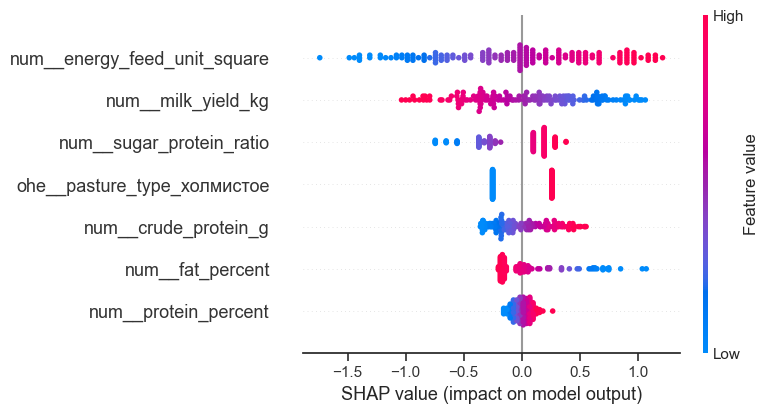

In [93]:
# Создание SHAP 
explainer = shap.LinearExplainer(model_four['model'], model_four['X_test'])

# Вычисление SHAP-значений
shap_values = explainer.shap_values(model_four['X_test'])
# Визуализация глобальной важности признаков
shap.summary_plot(shap_values, model_four['X_test'])

- Признаки отсортированы по важности (сверху вниз).
- Увеличение energy_feed_unit_square (например, более калорийный корм) повышает вероятность получения вкусного молока.
- Сахаро-протеиновое соотношение в корме положительно влияет на получение вкусного молока.


In [94]:
cow_buy.head(5)

breed pasture_type breed_daddy_bull  dad_name  fat_percent  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес         3.58   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный         3.54   
2  РефлешнСоверинг    равнинное          Соверин     Барин         3.59   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный         3.40   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный         3.64   

   protein_percent          age  energy_feed_unit_square  crude_protein_g  \
0            3.076  более_2_лет               233.361138      2019.947532   
1            3.081  менее_2_лет               233.361138      2019.947532   
2            3.074  более_2_лет               233.361138      2019.947532   
3            3.061  более_2_лет               233.361138      2019.947532   
4            3.074  более_2_лет               233.361138      2019.947532   

   sugar_protein_ratio spo_cat  milk_yield_kg  
0             0.958744    True    6549.598648  
1             0.958744    True    6330.157085  
2             0.958744    True    6295.602377  
3             0.958744    True    6570.869715  
4             0.958744    True    6564.018511

In [95]:
cow_buy_scaled = model_four['preprocessor'].transform(cow_buy)
taste_of_milk_pred = model_four['model'].predict_proba(cow_buy_scaled)[:,1]
cow_buy['taste_of_milk'] = taste_of_milk_pred

In [96]:
cow_buy['taste_of_milk'] = cow_buy['taste_of_milk'].round(2)

In [97]:
cow_buy = cow_buy.drop(['energy_feed_unit_square', 'spo_cat'], axis=1)

In [98]:
cow_buy = cow_buy.sort_values(by=['taste_of_milk', 'milk_yield_kg'], ascending=[False, False], kind = 'mergesort')
cow_buy.head(5)

breed pasture_type breed_daddy_bull  dad_name  fat_percent  \
13   Вис Бик Айдиал    холмистое          Соверин     Барин         3.42   
9   РефлешнСоверинг    холмистое           Айдиал    Буйный         3.40   
16   Вис Бик Айдиал    холмистое          Соверин  Соловчик         3.73   
0    Вис Бик Айдиал    холмистое           Айдиал  Геркулес         3.58   
6    Вис Бик Айдиал    холмистое           Айдиал  Геркулес         3.58   

    protein_percent          age  crude_protein_g  sugar_protein_ratio  \
13            3.075  менее_2_лет      2019.947532             0.958744   
9             3.079  менее_2_лет      2019.947532             0.958744   
16            3.079  более_2_лет      2019.947532             0.958744   
0             3.076  более_2_лет      2019.947532             0.958744   
6             3.076  более_2_лет      2019.947532             0.958744   

    milk_yield_kg  taste_of_milk  
13    6082.822384           0.87  
9     6374.054803           0.85  
16    6343.541250           0.77  
0     6549.598648           0.76  
6     6549.598648           0.76

Уберем столбцы, которые были добавлены для постороения модели. Оставим только коров, которые по прогнозу должны давать более 6000 кг молока удоя в год и с большой долей вероятности будут иметь вкусное молоко.

In [99]:
cow_buy = cow_buy.drop(['crude_protein_g', 'sugar_protein_ratio'], axis=1).query('milk_yield_kg>=6000 and taste_of_milk>0.8')


In [100]:
display(cow_buy)
len(cow_buy)

breed pasture_type breed_daddy_bull dad_name  fat_percent  \
13   Вис Бик Айдиал    холмистое          Соверин    Барин         3.42   
9   РефлешнСоверинг    холмистое           Айдиал   Буйный         3.40   

    protein_percent          age  milk_yield_kg  taste_of_milk  
13            3.075  менее_2_лет    6082.822384           0.87  
9             3.079  менее_2_лет    6374.054803           0.85

2

Таким образом, критериям фермера соответсвует 2 коровы. Это коровы с id 13 и 9.

## Итоговые выводы

Для фермерского хозяйства "Веселый луг" было проведено исследование в ходе которого было построены модели машинного обучения:
- модель линейной регрессии для предсказания удоя коров
- модель логистической регрессии для предсказания вкуса молока. 

Обучение моделей проводилось на данных фермерского хозяйства "Веселый луг", прогноз на данных "ЭкоФерма", где фермер планирует новую закупку скота.

В ходе предобработки данных:

- были изменены названия столбцов в соответсвии со стандартами
- удалены явные дубликаты.
- Скрытые дубликаты выявлены и удалены.

В ходе исследовательского анализа данных было установлено:

Коровы фермерского хозяйства "Веселый луг"
- Почти 60% буренок породы Вис Бик Айдиал
- 55% выгуливаются на холмистой местности, остальные на равнинной
- Буренки от быков 2-х пород: Соверин и Айдиал
- 60% молока по мнению фермера является вкусным
- 90% буренок старше 2 лет
- Коровы от 4-х быков, 70% от Барин и Буйный.
- Удой 6132.5 +/- 475.9 кг в год.

Молоко и корм "Веселый луг"
- Энергетическая кормовая единица 14.85 +/- 1.18
- Содержание сырого протеина, г 1915.5 +/- 182
- Сахаро-протеиновое соотношение в корме 0.93 +/- 0.03
- содержание жиров, % 3.076 +/- 0.076
- содержание белка, %  3.076 +/- 0.002

Коровы «ЭкоФермы»:
- Равное отношение коров по выгулу на равнинных и холмистых пастбищах.
- Поголовье буренок двух пород в равных отношениях
- Папы - быки двух пород, привалирует порода соверин
- Более 70% коров от быков Буйный и Геркулес
- Почти 70% коров старше 2 лет

Молоко "ЭкоФермы"
- жирность молока медианное значение 3.585, стандартное отклонение 0.142
- уровень белка практически постоянный, стандартное отклонение 0.011, медианное значение 3.0735

В ходе корреляционного анализа данных установлена:
Сильная корреляция удоя от характеристик корма:
- ЭКЕ (Энергетическая кормовая единица)/energy_feed_unit,
- СПО (Сахаро-протеиновое соотношение)/sugar_protein_ratio,
Умеренная корреляция от 
- Сырого протеина, г(crude_protein_g)
Сильная корреляция удоя от характеристики молока 
- Жирности,% (fat_percent). 

В зависимости от категориальных значений выявлены следующие зависимости:
- от породы папы быка (Айдиал дает больший удой при меньшем значении energy_feed_unit)
- Коровы старше 2 лет дают больший удой
- Максимальные показатели удоя от коров посущихся на холмистых пастбищах.

Была построена модель машиного обучения на базе линейной регрессии для прогнозирования удоя коров на основае таких входных признаков как:
- порода буренки
- порода папы быка
- имени папы быка
- типа пастбища
- возраста буренки
- показателя энергетической кормовой единицы
- показателя сырого протеина в корме
- сахаро- протеинового содержания.

Точность модели составляет 83.8%
Абсолютная ошибка прогноза +/- 151 кг молока в год

Модель расчитана на диапазон целевой характеристики от 5450  до 6964 кг молока в год

На основе полученной модели машинного обучения сделан прогноз удоя для буренок "ЭкоФерма". 
Все 20 буренок согласно прогнозу должны дать удой свыше 6000 кг молока в год

Далее была построена модель машинного обучения на базе логистистической регрессии. 

Входные признаки для логистической модели:
- Удой, 
- Сырой белок, 
- Сахаро - протеиновое соотношение, 
- Тип пастбища,  
- Жирность молока,  
- Содержание белка в молоке, 
- ЭКЕ в квадрате.

Целевой признак - вкус молока. 1- вкусное, 0 - не вкусное.


Точность модели accuracy = 0.637
При коэффициенте precision = 0.8 модель не дает ложно положительных ответов на тестовой выборке.
В итоговой таблице вкус молока задан вероятностью (precision) с которой молоко окажется вкусным. 

Критериям фермера соответсвует 2 коровы. Это коровы с id 13 и 9. 

In [101]:
cow_buy

breed pasture_type breed_daddy_bull dad_name  fat_percent  \
13   Вис Бик Айдиал    холмистое          Соверин    Барин         3.42   
9   РефлешнСоверинг    холмистое           Айдиал   Буйный         3.40   

    protein_percent          age  milk_yield_kg  taste_of_milk  
13            3.075  менее_2_лет    6082.822384           0.87  
9             3.079  менее_2_лет    6374.054803           0.85